In [5]:
#Interpretation of the models: how to say that one is accurate? It should ideally be equivalent to the POU at a national scale. How to do that? 
#todo: priority 2, Data Analysis Section: Loading in empirical data. particularlly price data
#todo: priority 2, processing section, particularlly for making a seasonal profile
#todo: priority 4, processing section, functions for generating comparable summaries of monthly admin1 alpha/fcs data
# -correlation of alpha and ipc phase [for ~2016 - 2024] or fcs [for ~2017-2022] (monthly) at admin 1 level
#    -> requires just detrending (two experiments: variability and trend correlations) + date alignment (which could be +/- a month or two perhaps) + correlation()
# -also possible to compare seasonal profiles?
#todo: priority 4, processing section, functions for generating comparable summaries of yearly admin1 alpha/fcs data
# - correlation of yearly mean alpha with yearly mean ipc/fcs
#     - > should be just mean + correlation
# 


# Data Analysis Section
Loading in observational data on food security

##### Prices Data

In [6]:
import pandas as pd 
import numpy as np
Tanzania_Market_Prices = pd.read_csv(r"../Data/2DSUM-Gridded/WFP-mVAM_RetailFoodPrices-Tanzania_2019-2025.csv")
all_market_prices = pd.read_csv(r"../Data//2DSUM-Gridded/WFP-mVAM_RetailFoodPrices-SenBKEgyAng-etc_2019-2025.csv")
all_market_prices.Country.unique()

array(['Angola', 'Burkina Faso', 'Democratic Republic of the Congo',
       'Ethiopia', 'Zimbabwe', 'Senegal', 'Egypt'], dtype=object)

##### Food Security Data

In [7]:
fs_data_harmonized = pd.read_csv(r'C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\HFID_hv1.csv')

# Processing Function Definitions Section

In [8]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
def seasonal_profile(pdseries,label=" "):

    # Calculate monthly profile of alpha for a given region
    # Group by month, calculate statistics

    monthly_alpha_by_region = pdseries.groupby(level='month')
    monthly_alpha_mean = monthly_alpha_by_region.mean()
    monthly_alpha_std = monthly_alpha_by_region.std()

    # Create a DataFrame with statistics for easy plotting
    stats_df = pd.DataFrame({
        'Mean': monthly_alpha_mean,
        'Std Dev': monthly_alpha_std,
        'Min': monthly_alpha_by_region.min(),
        'Max': monthly_alpha_by_region.max(),
        'Sample Count': monthly_alpha_by_region.count()
    })

    # Plot monthly alpha profile with standard deviation
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        x=monthly_alpha_mean.index,
        y=monthly_alpha_mean.values,
        yerr=monthly_alpha_std.values,
        fmt='o-',
        capsize=5,
        ecolor='gray',
        linewidth=2,
        label=f'Monthly Alpha (Mean ± Std Dev) for {label}'
    )

    # Add month names on x-axis
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    plt.xticks(range(1, 13), month_names)

    # Add reference lines
    plt.axhline(1.0, color='green', linestyle='--', linewidth=0.8, label='Full Sufficiency (Alpha=1)')
    plt.axhline(0.8, color='orange', linestyle=':', linewidth=0.7, label='80% Sufficiency')
    plt.axhline(0.5, color='red', linestyle=':', linewidth=0.7, label='50% Sufficiency')

    # Add labels and customize plot
    plt.title(f'Monthly Food Sufficiency Profile for {label}', fontsize=14)
    plt.xlabel('Month', fontsize=12)
    plt.ylabel('Alpha (Food Sufficiency Ratio)', fontsize=12)
    plt.ylim(0, 1.1)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()

    # Display stats table
    print(f"Monthly Alpha Statistics for: {label}")
    print(stats_df)

    plt.tight_layout()
    plt.show()

 # Modeling Section  
 # This First part loads all necessary data and performs initial transformations.

In [9]:
# Common Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore') # Suppress warnings for cleaner output
sub_saharan_africa_list = [
    'Angola',
    'Benin',
    'Botswana',
    'Burkina Faso',
    'Burundi',
    'Cabo Verde', # Note: Your list has 'Cape Verde'
    'Cape Verde', # Include the name as it appears in your list
    'Cameroon',
    'Central African Republic',
    'Chad',
    'Comoros',
    'Congo', # Refers to the Republic of the Congo
    'Democratic Republic of the Congo',
    "Côte d'Ivoire",
    'Djibouti',
    'Equatorial Guinea',
    'Eritrea',
    'Eswatini',
    'Ethiopia',
    'Gabon',
    'Gambia',
    'Ghana',
    'Guinea',
    'Guinea-Bissau',
    'Kenya',
    'Lesotho',
    'Liberia',
    'Madagascar',
    'Malawi',
    'Mali',
    'Mauritania',
    'Mauritius',
    'Mayotte', # French overseas department, geographically included
    'Mozambique',
    'Namibia',
    'Niger',
    'Nigeria',
    'Réunion', # French overseas department, geographically included
    'Rwanda',
    'Saint Helena', # British Overseas Territory, geographically included
    'Sao Tome and Principe',
    'Senegal',
    'Seychelles',
    'Sierra Leone',
    'Somalia',
    'South Africa',
    'South Sudan',
    'Sudan', # Often included, though sometimes grouped with North Africa
    'Swaziland', # Older name for Eswatini, present in your list
    'Togo',
    'Uganda',
    'United Republic of Tanzania', # Matches the name in your list
    'Zambia',
    'Zimbabwe'
]


In [10]:
# Data for National Model
FoodConsumptionSurveyShares_National_Data = pd.read_csv(r"..\Data\1DSUM\FAOSTAT_Intake-national-surveys-allfoodgroups.csv")
National_Income_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-income_1970-2022.csv")
National_Trade_Data_National = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-importexports-1961-2023.csv") #Renamed to avoid conflict
National_AgEmpShares_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-employmentsharesagriculture-2000-2021.csv")
National_Populations_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-population+ruralurban_1950-2023.csv") # Used by National and National Monthly
National_Cereals_Production_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_national-cereals-production_1961-2023.csv")
National_Food_Security_Indicators_Data = pd.read_csv(r"../Data\1DSUM-National\FAOSTAT_4FoodSecurityIndicators-SSA-MinusSouthAfrica.csv")

# Combine old and new FBS national data
df_old_national_fbs = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_1961-2013.csv')
df_new_national_fbs = pd.read_csv('../Data/1DSUM-National/FAOSTAT_FBS-Cereals-National-Africa_2010-2022.csv')
df_old_national_fbs['Year'] = pd.to_numeric(df_old_national_fbs['Year'], errors='coerce')
df_new_national_fbs['Year'] = pd.to_numeric(df_new_national_fbs['Year'], errors='coerce')
df_old_national_fbs_filtered = df_old_national_fbs[df_old_national_fbs['Year'] <= 2009]
FBS_Cereals_Complete_National = pd.concat([df_old_national_fbs_filtered, df_new_national_fbs], ignore_index=True)
FBS_Cereals_Complete_National = FBS_Cereals_Complete_National.sort_values(by='Year').reset_index(drop=True)
FBS_Cereals_Complete_National['Element'].replace({"Import Quantity": "Import quantity", "Export Quantity": "Export quantity"}, inplace=True)
#todo: priority 1: change w/ roots + tubers 

# Data for National Monthly Model
National_Crop_Calendar_Data = pd.read_csv(r"..\Data/1DSUM-National/crop_calendar_gaul0.csv", delimiter=';')
Angola_Monthly_Trade_Data = pd.read_csv(r"..\Data\trade\Angola_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
Senegal_Monthly_Trade_Data_Raw = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\Senegal_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")
BurkinaFaso_Monthly_Trade_Data = pd.read_csv(r"C:\Users\danie\OneDrive\Desktop\M2 Internship\Data\trade\BurkinaFaso_Monthly_Trade_Rice-Maize-Wheat-Sorghum-Barley-Oats-Millet-Rye_2000-2025")

# Concatenate Senegal, Burkina Faso, and Angola monthly trade data
Combined_Monthly_Trade_Data = pd.concat([Senegal_Monthly_Trade_Data_Raw, BurkinaFaso_Monthly_Trade_Data, Angola_Monthly_Trade_Data])

# Data for IPC Analysis (related to National/Monthly context)
IPC_Data = pd.read_excel(r"C:\Users\danie\Downloads\cadre_harmonise_caf_ipc.xlsx")


 ---

 # National Model

 ## Data Processing - National Model

In [11]:
# Food Survey Consumption Share data analysis (National context)
def split_names_national_func(name_str): # Renamed function
    try:
        name_part = int(name_str.split("-")[1])
    except ValueError: # Handles if the part is not an int
        try:
            name_part = int(name_str.split("-")[2])
        except (ValueError, IndexError): # Handles non-int and missing part
            name_part = np.nan 
    except IndexError: # Handles if name doesn't have enough parts
        name_part = np.nan
    return name_part

FoodConsumptionSurveyShares_National_Data["Country"] = [name.split("-")[0] for name in FoodConsumptionSurveyShares_National_Data["Survey"].values]
FoodConsumptionSurveyShares_National_Data["Year"] = [split_names_national_func(name) for name in FoodConsumptionSurveyShares_National_Data["Survey"].values]
FoodConsumptionSurveyShares_National_Data.dropna(subset=['Year'], inplace=True)
FoodConsumptionSurveyShares_National_Data["Year"] = FoodConsumptionSurveyShares_National_Data["Year"].astype(int)

# Example analysis (original script had print statements inside loop):
cereal_ratios_national_list = []
# for country_nat_fcs in FoodConsumptionSurveyShares_National_Data["Country"].unique():
#     country_data_fcs = FoodConsumptionSurveyShares_National_Data[
#         (FoodConsumptionSurveyShares_National_Data["Geographic Level"] == 'National') &
#         (FoodConsumptionSurveyShares_National_Data["Country"] == country_nat_fcs)
#     ]
#     # ... further processing would go here ...
# print(f"Processed national cereal ratios (example). List length: {len(cereal_ratios_national_list)}")


 ---

 # National Monthly Model

## Data Processing - National Monthly Model (Crop Calendar)


In [12]:

# %%
def dekad_to_month_func(dekad_val): return min(12, max(1, (dekad_val - 1) // 3 + 1))
National_Crop_Calendar_Data['harvest_start_month'] = National_Crop_Calendar_Data['eos_s'].apply(dekad_to_month_func)
National_Crop_Calendar_Data['harvest_end_month'] = National_Crop_Calendar_Data['eos_e'].apply(dekad_to_month_func)

def create_harvest_array_func(start_month_val, end_month_val):
    arr_harvest = np.zeros(12)
    if start_month_val <= end_month_val:
        for month_h in range(start_month_val, end_month_val + 1): arr_harvest[month_h - 1] = 1
    else: 
        for month_h in range(start_month_val, 13): arr_harvest[month_h - 1] = 1
        for month_h in range(1, end_month_val + 1): arr_harvest[month_h - 1] = 1
    if arr_harvest.sum() > 0: arr_harvest = arr_harvest / arr_harvest.sum()
    return arr_harvest
National_Crop_Calendar_Data['monthly_harvest_proportions'] = National_Crop_Calendar_Data.apply(lambda row: create_harvest_array_func(row['harvest_start_month'], row['harvest_end_month']), axis=1)




## Simulation - National Monthly Model


In [14]:
FBS_Cereals_Complete_National.Element.unique()

array(['Production', 'Seed', 'Import quantity',
       'Domestic supply quantity', 'Food supply (kcal/capita/day)',
       'Food', 'Losses', 'Food supply quantity (kg/capita/yr)', 'Feed',
       'Export quantity', 'Stock Variation', 'Processing',
       'Other uses (non-food)', 'Residuals', 'Food supply (kcal)',
       'Tourist consumption'], dtype=object)

In [ ]:
I need you to complete the code below, which is a continuation of the previous code example. The code is designed to run a simulation for various experiments related to food sufficiency and trade in selected nations, using monthly data. The simulation calculates food sufficiency ratios (alpha) based but on a downsclaed monthly basis from yearly fbs data combined with monthly trade data and crop calendar. 
Will need a mapping from items in trade data to items in the FBS, as they are not identical. likely very nearly will working using an isin but maybe a manual approach is needed.


###########Start Previous Code Example
cereal_caloric_density_monthly_param = 2609 * 1000; caloric_requirement_monthly_param = 1240 * 365 / 12
experiments_monthly_list = ["VariedTrade", "ConstTrade", "StockDepreciation", "NoTrade"]
seasonal_results_monthly_dict = {exp: {} for exp in experiments_monthly_list}

national_years_monthly_setup = FBS_Cereals_Complete_National.Year.unique()
national_years_monthly_sim = national_years_monthly_setup[-(30 if len(national_years_monthly_setup) >=30 else len(national_years_monthly_setup)):] # Ensure we don't go out of bounds
target_nations_monthly_list = ['Senegal', 'Burkina Faso', 'Angola']
target_nations_monthly_sim = [n_mon for n_mon in target_nations_monthly_list if n_mon in FBS_Cereals_Complete_National.Area.unique() and n_mon in National_Populations_Data.Area.unique() and n_mon in National_Crop_Calendar_Data.name0_shr.unique() and n_mon in Combined_Monthly_Trade_Data.reporterDesc.unique()]

if not target_nations_monthly_sim: print("Warning: No target nations for monthly simulation after filtering. Check data.")

for experiment_name_mon in experiments_monthly_list:
    num_time_steps_mon = len(national_years_monthly_sim) * 12
    sim_stocks_monthly_arr = np.zeros((len(target_nations_monthly_sim), num_time_steps_mon))
    sim_alpha_monthly_arr = np.ones((len(target_nations_monthly_sim), num_time_steps_mon))
    print(f"Running Monthly Experiment: {experiment_name_mon}")

    for r_idx_mon, nation_name_monthly_sim in enumerate(target_nations_monthly_sim):
        seed_monthly_param, loss_monthly_param = 0.03, 0.04
        # sim_stocks_monthly_arr[r_idx_mon, 0] = 0.01 # Initial stock for t=0

        for i_idx_mon, year_val_monthly_sim in enumerate(national_years_monthly_sim):
            #
            
            for month_idx_mon in np.arange(12):
                current_sim_step_mon = 12 * i_idx_mon + month_idx_mon
                processing_monthly_param, economic_use_monthly_param, residuals_monthly_param = 0,0,0
                
                pop_start_series_mon = National_Populations_Data[(National_Populations_Data.Year == year_val_monthly_sim) & (National_Populations_Data.Area == nation_name_monthly_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
                next_year_val = year_val_monthly_sim + 1
                max_pop_year = National_Populations_Data.Year.max()
                if next_year_val > max_pop_year: next_year_val = max_pop_year # Cap to max available year
                
                pop_end_series_mon = National_Populations_Data[(National_Populations_Data.Year == next_year_val) & (National_Populations_Data.Area == nation_name_monthly_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
                if pop_end_series_mon.empty: pop_end_series_mon = pop_start_series_mon # Use current if next year's data is missing
                
                Pop_val_monthly_sim = 0
                if not pop_start_series_mon.empty and not pop_end_series_mon.empty:
                     Pop_val_monthly_sim = 1000 * (pop_start_series_mon.values[0] + (month_idx_mon / 12.0) * (pop_end_series_mon.values[0] - pop_start_series_mon.values[0]))
                elif not pop_start_series_mon.empty: Pop_val_monthly_sim = 1000 * pop_start_series_mon.values[0]
                #todo: priority 0... below, shuold work just having replaced FBS_Cerals...with FBS_CerealsRoots
                Y_val_monthly_sim = 0
                annual_production_items_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_monthly_sim) & (FBS_Cereals_Complete_National.Element == 'Production') & (FBS_Cereals_Complete_National.Area == nation_name_monthly_sim)]
                for _, item_row_mon in annual_production_items_mon.iterrows():
                    cereal_item_name_mon, annual_prod_value_mon = item_row_mon['Item'], item_row_mon['Value']
                    crop_short_name_mon = cereal_item_name_mon.split(' ')[0]
                    harvest_percentage_mon = 1/12
                    calendar_entry_mon = National_Crop_Calendar_Data[(National_Crop_Calendar_Data.name0_shr == nation_name_monthly_sim) & (National_Crop_Calendar_Data.crop_name == crop_short_name_mon)]
                    if not calendar_entry_mon.empty: harvest_percentage_mon = calendar_entry_mon.monthly_harvest_proportions.iloc[0][month_idx_mon]
                    Y_val_monthly_sim += 1000 * harvest_percentage_mon * annual_prod_value_mon
                
                annual_imports_fbs_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_monthly_sim)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == nation_name_monthly_sim)]["Value"].sum() * 1000
                annual_exports_fbs_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_monthly_sim)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == nation_name_monthly_sim)]["Value"].sum() * 1000
                imports_prop_mon, exports_prop_mon = 1/12, 1/12

                if experiment_name_mon == "VariedTrade":
                    monthly_trade_nation_year_mon = Combined_Monthly_Trade_Data[(Combined_Monthly_Trade_Data.reporterDesc == nation_name_monthly_sim) & (Combined_Monthly_Trade_Data.refYear == year_val_monthly_sim)]
                    if not monthly_trade_nation_year_mon.empty:
                        imports_month_val_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Import") & (monthly_trade_nation_year_mon.partnerDesc == "World") & (monthly_trade_nation_year_mon.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000
                        exports_month_val_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Export") & (monthly_trade_nation_year_mon.partnerDesc == "World") & (monthly_trade_nation_year_mon.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000
                        imports_year_total_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Import") & (monthly_trade_nation_year_mon.partnerDesc == "World")].netWgt.sum() / 1000
                        exports_year_total_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Export") & (monthly_trade_nation_year_mon.partnerDesc == "World")].netWgt.sum() / 1000
                        imports_prop_mon = imports_month_val_mon / imports_year_total_mon if imports_year_total_mon != 0 else (1/12 if imports_month_val_mon > 0 else 0)
                        exports_prop_mon = exports_month_val_mon / exports_year_total_mon if exports_year_total_mon != 0 else (1/12 if exports_month_val_mon > 0 else 0)
                elif experiment_name_mon == "NoTrade": imports_prop_mon, exports_prop_mon = 0,0
                
                trade_balance_val_monthly_sim = (imports_prop_mon * annual_imports_fbs_mon) - (exports_prop_mon * annual_exports_fbs_mon)
                food_demand_monthly_sim = Pop_val_monthly_sim * caloric_requirement_monthly_param / cereal_caloric_density_monthly_param if Pop_val_monthly_sim > 0 else 0
                total_supply_monthly_sim = Y_val_monthly_sim + trade_balance_val_monthly_sim
                food_supply_term_monthly_sim = food_demand_monthly_sim * (1 + processing_monthly_param)
                
                prev_stock_mon = sim_stocks_monthly_arr[r_idx_mon, current_sim_step_mon - 1] if current_sim_step_mon > 0 else 0.01 # Initial stock if t=0
                available_for_food_monthly_sim = prev_stock_mon + trade_balance_val_monthly_sim + Y_val_monthly_sim * (1 - seed_monthly_param - loss_monthly_param) - total_supply_monthly_sim * economic_use_monthly_param

                if food_supply_term_monthly_sim == 0: sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon] = 1
                elif available_for_food_monthly_sim >= food_supply_term_monthly_sim: sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon] = 1
                else: sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon] = np.clip(available_for_food_monthly_sim / food_supply_term_monthly_sim, 0, 1)
                
                # dstock logic:
                dstock_monthly_sim_val = trade_balance_val_monthly_sim + Y_val_monthly_sim*(1-seed_monthly_param-loss_monthly_param) \
                                         - sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon]*food_demand_monthly_sim \
                                         - total_supply_monthly_sim*(economic_use_monthly_param + processing_monthly_param + residuals_monthly_param)
                current_month_stock_val = prev_stock_mon + dstock_monthly_sim_val
                if experiment_name_mon == "StockDepreciation": current_month_stock_val -= prev_stock_mon * (0.34) 
                sim_stocks_monthly_arr[r_idx_mon, current_sim_step_mon] = current_month_stock_val

    seasonal_results_monthly_dict[experiment_name_mon]["NationalStocks"] = sim_stocks_monthly_arr
    seasonal_results_monthly_dict[experiment_name_mon]["NationalAlpha"] = sim_alpha_monthly_arr

#End Previous Code Example

##########Start Pseudocode for the new National Monthly Model##########
for country in target_countries
    cereal_cal_demand = cereal_cal_demands[country] #kcal/person/day
    cereals_densities = {
        'Rice': 0.85,  # kg per kcal
        'Maize': 0.75,  # kg per kcal
        'Wheat': 0.80,  # kg per kcal
        'Sorghum': 0.70,  # kg per kcal
        'Barley': 0.65,  # kg per kcal
        'Oats': 0.60,  # kg per kcal
        'Millet': 0.75,  # kg per kcal
        'Rye': 0.70,   # kg per kcal
        'Other': 0.70 #kg per kcal 
    }
    calorie_stock_yr = 0 # allow calorie_stock to carry over years
    for year in years
            for month in months
                for fooditem in fooditems:
                    #
                    #below calculating the yearly values of constants for each item
                    #
                    seed_proportion_yr = FBS_Cereals_Complete_National.Element=='Seed'&item=fooditem. / FBS_Cereals_Complete_National.Element=='Production'
                    loss proportion_yr = Element Losses / Production
                    net_production_yr = production*(1-seed_proportion-loss_proportion)
                    total_supply_yr = net_production + imports - exports     
                    processing_yr = processing/total supply
                    Feed_yr = feed/total supply  
                    tourist_cons_yr = tourist consumption/total supply
                    other_uses_yr = other uses/total supply
                    stock_variation_yr = stock_variation
                    #
                    #below now calculating the monthly values now, using the crop calendar + trade data
                    #    
                    net_production = production*(1-seed_proportion-loss_proportion)
                    total_supply = net_production + imports - exports
                    available_fooditem = total_supply*(1-(processing + feed + tourist_cons + other_uses)) - stock_variation_yr/1
                    calorie_stock_yr += available_fooditem * cereals_densities[fooditem] 
                # now we have the calorie stock for the year, we can calculate the monthly consumption
                if calorie_stock_yr/pop > cereal_cal_demand:
                    consumption_month = cereal_cal_demand*pop
                    calorie_stock_yr -= consumption_month
                if calorie_stock_yr/pop < cereal_cal_demand:
                    consumption_month = calorie_stock_yr/pop
                    calorie_stock_yr = 0
                alpha_month = consumption_month / cereal_cal_demand #store this. 
                
##########End Pseudocode for the new National Monthly Model##########

##########Start Unique items between trade and fbs datasets#########
FBS_Cereals_Complete_National.Item.unique() = array(['Wheat and products', 'Oats', 'Maize and products',
       'Rice (Milled Equivalent)', 'Cereals, Other',
       'Barley and products', 'Rye and products', 'Sorghum and products',
       'Millet and products', 'Cereals, other', 'Rice and products'],
      dtype=object)

Combined_Monthly_Trade_Data.cmdDesc.unique()  = array(['Rice', 'Maize (corn)', 'Wheat and meslin', 'Grain sorghum',
       'Barley', 'Oats',
       'Buckwheat, millet and canary seeds; other cereals', 'Rye',
       'Buckwheat, millet and canary seed; other cereals'], dtype=object)
##########End Unique items between trade and fbs datasets#########

        

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (FBS),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,FBSH,"Food Balances (-2013, old methodology and popu...",12,Algeria,5511,Production,S2511,Wheat and products,1961,1961,1000 t,686.00,I,Imputed value,NaN
1,FBSH,"Food Balances (-2013, old methodology and popu...",646,Rwanda,5527,Seed,S2511,Wheat and products,1961,1961,1000 t,0.00,I,Imputed value,NaN
2,FBSH,"Food Balances (-2013, old methodology and popu...",508,Mozambique,5611,Import quantity,S2516,Oats,1961,1961,1000 t,0.00,I,Imputed value,NaN
3,FBSH,"Food Balances (-2013, old methodology and popu...",148,Chad,5301,Domestic supply quantity,S2514,Maize and products,1961,1961,1000 t,9.00,I,Imputed value,NaN
4,FBSH,"Food Balances (-2013, old methodology and popu...",204,Benin,664,Food supply (kcal/capita/day),S2805,Rice (Milled Equivalent),1961,1961,kcal/cap/d,11.80,E,Estimated value,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238595,FBS,Food Balances (2010-),504,Morocco,664,Food supply (kcal/capita/day),S2515,Rye and products,2022,2022,kcal/cap/d,0.36,E,Estimated value,NaN
238596,FBS,Food Balances (2010-),504,Morocco,661,Food supply (kcal),S2515,Rye and products,2022,2022,million Kcal,4862.36,I,Imputed value,NaN
238597,FBS,Food Balances (2010-),504,Morocco,5511,Production,S2516,Oats,2022,2022,1000 t,4.00,I,Imputed value,NaN
238598,FBS,Food Balances (2010-),504,Morocco,5072,Stock Variation,S2516,Oats,2022,2022,1000 t,0.00,I,Imputed value,NaN


In [22]:
# Define canonical item names (can be adjusted based on detailed analysis)
CANONICAL_CEREALS = ['Rice', 'Maize', 'Wheat', 'Sorghum', 'Barley', 'Oats', 'Millet', 'Rye', 'Cereals, Other']

# --- Mapping from FBS Item names to Canonical names ---
fbs_to_canonical_mapping = {
    'Wheat and products': 'Wheat',
    'Oats': 'Oats',
    'Maize and products': 'Maize',
    'Rice (Milled Equivalent)': 'Rice', # This is important, FBS rice is often milled.
    'Rice and products': 'Rice', # Handle variations
    'Cereals, Other': 'Cereals, Other',
    'Cereals, other': 'Cereals, Other', # Handle variations
    'Barley and products': 'Barley',
    'Rye and products': 'Rye',
    'Sorghum and products': 'Sorghum',
    'Millet and products': 'Millet'
}

# --- Mapping from Trade cmdDesc to Canonical names ---
trade_to_canonical_mapping = {
    'Rice': 'Rice',
    'Maize (corn)': 'Maize',
    'Wheat and meslin': 'Wheat',
    'Grain sorghum': 'Sorghum',
    'Barley': 'Barley',
    'Oats': 'Oats',
    'Buckwheat, millet and canary seeds; other cereals': 'Millet', # Simplification: grouping these with Millet or 'Cereals, Other'
                                                                    # For more accuracy, "other cereals" here could map to "Cereals, Other"
                                                                    # and Millet separately if trade data allows.
                                                                    # Let's refine: if "millet" is in string, map to Millet, else Other
    'Buckwheat, millet and canary seed; other cereals': 'Millet', # Same as above
    'Rye': 'Rye'
}
# A more refined trade mapping for "Buckwheat, millet..."
def smart_trade_map(trade_desc):
    desc_lower = trade_desc.lower()
    if 'millet' in desc_lower:
        return 'Millet'
    if 'wheat' in desc_lower or 'meslin' in desc_lower:
        return 'Wheat'
    if 'maize' in desc_lower or 'corn' in desc_lower:
        return 'Maize'
    if 'rice' in desc_lower:
        return 'Rice'
    if 'sorghum' in desc_lower:
        return 'Sorghum'
    if 'barley' in desc_lower:
        return 'Barley'
    if 'oats' in desc_lower:
        return 'Oats'
    if 'rye' in desc_lower:
        return 'Rye'
    # Add more specific cases if needed
    if 'buckwheat' in desc_lower or 'canary' in desc_lower or 'other cereals' in desc_lower:
        return 'Cereals, Other' # Group remaining into 'Cereals, Other'
    return None # Should not happen if all trade items are covered

# --- Mapping from Crop Calendar crop_name to Canonical names ---
# Crop calendar names are often already simplified (e.g., 'Maize', 'Rice').
# We'll assume direct match or minor adjustments.
# Example: National_Crop_Calendar_Data['crop_name'].unique() might give ['Maize', 'Rice', 'Wheat', 'Sorghum', 'Millet', 'Barley']
# This mapping might need to be more robust depending on actual unique values in National_Crop_Calendar_Data['crop_name']
crop_calendar_to_canonical_mapping = {
    # Example: if crop_calendar has 'Maize (corn)' but we want 'Maize'
    # 'Maize (corn)': 'Maize',
    # For now, assume direct use and handle missing by falling back to 1/12 distribution later
}

# --- Cereal Caloric Densities (kcal per kg) ---
# The pseudocode had kg/kcal, which is inverse. Assuming kcal/kg.
# Typical values: Rice ~3600, Maize ~3600, Wheat ~3400 kcal/kg (raw, uncooked)
# These are illustrative and should be verified/sourced properly.
# The previous `cereal_caloric_density_monthly_param` was 2609 kcal/kg.
# We'll use a dictionary with canonical names.
cereals_densities_kcal_per_kg = {
    'Rice': 3650,    # kcal/kg (milled rice)
    'Maize': 3620,   # kcal/kg
    'Wheat': 3400,   # kcal/kg
    'Sorghum': 3390, # kcal/kg
    'Barley': 3520,  # kcal/kg
    'Oats': 3890,    # kcal/kg (rolled oats higher, whole groats lower)
    'Millet': 3780,  # kcal/kg
    'Rye': 3380,     # kcal/kg
    'Cereals, Other': 3400 # Average or representative value
}
# Convert to kcal per ton for consistency with other quantity units (1000 kg = 1 ton)
cereals_densities_kcal_per_ton = {item: val * 1000 for item, val in cereals_densities_kcal_per_kg.items()}


# Helper function to get FBS values safely
def get_fbs_value(df, area, year, item_canonical, element, fbs_map):
    # Find FBS item name(s) that map to this canonical item
    fbs_item_names = [fbs_name for fbs_name, can_name in fbs_map.items() if can_name == item_canonical]
    if not fbs_item_names:
        # print(f"Warning: No FBS mapping for canonical item {item_canonical} in {area}, {year}, {element}")
        return 0

    value = df[
        (df['Area'] == area) &
        (df['Year'] == year) &
        (df['Item'].isin(fbs_item_names)) & # Use isin for multiple possible FBS names
        (df['Element'] == element)
    ]['Value'].sum() # Sum if multiple FBS items map to one canonical (e.g. "Rice and products", "Rice (Milled Equivalent)")
    return value if pd.notna(value) else 0

In [51]:
# --- Modified National Monthly Simulation ---

# Assume cereal_cal_demand_kcal_person_day is defined per country (e.g., from a dictionary or another data source)
# For this example, let's use a fixed value or the one derived from caloric_requirement_monthly_param
# caloric_requirement_monthly_param was kcal/person/month
# caloric_requirement_daily_param = (1240 * 365) / 365 # This is 1240 kcal/person/day
# Let's assume this 1240 is the target *from cereals*.
DEFAULT_CEREAL_CAL_DEMAND_PERSON_DAY = 1240 # kcal/person/day from cereals

# (Keep existing setup for experiments_monthly_list, seasonal_results_monthly_dict, years, target nations)
# ... (previous setup code for these variables) ...
national_years_monthly_setup = FBS_Cereals_Complete_National.Year.unique()
national_years_monthly_sim = national_years_monthly_setup[-(30 if len(national_years_monthly_setup) >=30 else len(national_years_monthly_setup)):]
target_nations_monthly_list = ['Angola']
target_nations_monthly_sim = [n_mon for n_mon in target_nations_monthly_list if n_mon in FBS_Cereals_Complete_National.Area.unique() and n_mon in National_Populations_Data.Area.unique() and n_mon in National_Crop_Calendar_Data.name0_shr.unique() and n_mon in Combined_Monthly_Trade_Data.reporterDesc.unique()]

experiments_monthly_list = ["VariedTrade", "ConstTrade", "StockDepreciation", "NoTrade"] # Ensure this is defined
seasonal_results_monthly_dict_new = {exp: {} for exp in experiments_monthly_list} # New dict for this model

if not target_nations_monthly_sim: print("Warning: No target nations for new monthly simulation after filtering.")

for experiment_name_mon in experiments_monthly_list:
    print(f"Running NEW Monthly Experiment: {experiment_name_mon}")
    num_total_months = len(national_years_monthly_sim) * 12
    
    # Store results: alpha per country, per month
    # We'll also store monthly calorie stock and consumption for diagnostics
    sim_alpha_monthly_new = np.ones((len(target_nations_monthly_sim), num_total_months))
    sim_calorie_stock_eom = np.zeros((len(target_nations_monthly_sim), num_total_months)) # End of Month calorie stock
    sim_monthly_kcal_consumed = np.zeros((len(target_nations_monthly_sim), num_total_months))

    for r_idx_mon, nation_name_monthly_sim in enumerate(target_nations_monthly_sim):
        print(f"  Processing Nation: {nation_name_monthly_sim}")
        # Initialize calorie stock for this nation (carries over years)
        current_calorie_stock = 0.0 # kcal

        # Get the per-person daily caloric demand from cereals for this country
        # This could be made country-specific if data is available
        cereal_cal_demand_person_day = DEFAULT_CEREAL_CAL_DEMAND_PERSON_DAY

        for i_idx_mon, year_val_monthly_sim in enumerate(national_years_monthly_sim):
            # --- Pre-calculate yearly proportions for each food item for THIS NATION and THIS YEAR ---
            yearly_item_proportions = {}
            total_fbs_food_kcal_for_year_target = 0 # Target for constraint
            print(f"    Year: {year_val_monthly_sim}")
            for canonical_item_name in CANONICAL_CEREALS:
                # Get annual FBS values for this item
                fbs_prod_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Production', fbs_to_canonical_mapping) * 1000 # to tons
                fbs_seed_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Seed', fbs_to_canonical_mapping) * 1000
                fbs_loss_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Losses', fbs_to_canonical_mapping) * 1000
                fbs_imports_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Import quantity', fbs_to_canonical_mapping) * 1000
                fbs_exports_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Export quantity', fbs_to_canonical_mapping) * 1000
                
                fbs_feed_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Feed', fbs_to_canonical_mapping) * 1000
                fbs_processing_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Processing', fbs_to_canonical_mapping) * 1000
                fbs_other_uses_yr = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Other uses (non-food)', fbs_to_canonical_mapping) * 1000
                fbs_stock_variation_yr = -1*get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Stock Variation', fbs_to_canonical_mapping) * 1000 # Positive is addition to stock
                
                # Calculate target food calories for constraint
                fbs_food_qty_yr_tons = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Food', fbs_to_canonical_mapping) * 1000 # to tons
                item_density_kcal_ton = cereals_densities_kcal_per_ton.get(canonical_item_name, 2609 * 1000) # Fallback to avg
                total_fbs_food_kcal_for_year_target += fbs_food_qty_yr_tons * item_density_kcal_ton

                # Calculate proportions based on annual data
                seed_prop_yr = fbs_seed_yr / fbs_prod_yr if fbs_prod_yr > 0 else 0
                loss_prop_yr = fbs_loss_yr / fbs_prod_yr if fbs_prod_yr > 0 else 0
                
                # Net production after seed and loss (annual for the item)
                net_production_item_yr = fbs_prod_yr * (1 - seed_prop_yr - loss_prop_yr)
                
                # Total annual supply for the item from FBS perspective
                # This definition of total_supply_item_yr is for calculating proportions of other uses.
                # It does not include stock variation for this purpose.
                total_supply_item_for_props_yr = net_production_item_yr + fbs_imports_yr - fbs_exports_yr
                
                feed_prop_item_yr = fbs_feed_yr / total_supply_item_for_props_yr if total_supply_item_for_props_yr > 0 else 0
                processing_prop_item_yr = fbs_processing_yr / total_supply_item_for_props_yr if total_supply_item_for_props_yr > 0 else 0
                other_uses_prop_item_yr = fbs_other_uses_yr / total_supply_item_for_props_yr if total_supply_item_for_props_yr > 0 else 0
                # Tourist consumption is not explicitly in the provided FBS unique items, but could be added if present. For now, assume it's part of "Other uses" or negligible.

                yearly_item_proportions[canonical_item_name] = {
                    'fbs_prod_yr': fbs_prod_yr, # Store annual production for monthly distribution
                    'seed_prop_yr': seed_prop_yr,
                    'loss_prop_yr': loss_prop_yr,
                    'feed_prop_item_yr': feed_prop_item_yr,
                    'processing_prop_item_yr': processing_prop_item_yr,
                    'other_uses_prop_item_yr': other_uses_prop_item_yr,
                    'fbs_stock_variation_yr': fbs_stock_variation_yr # Annual stock change for this item
                }

            # --- Monthly Loop ---
            monthly_kcal_consumed_this_year = 0 # For checking constraint

            for month_idx_mon in np.arange(12):
                current_sim_step_mon = 12 * i_idx_mon + month_idx_mon
                
                # Interpolate Population for the month
                pop_start_series_mon = National_Populations_Data[(National_Populations_Data.Year == year_val_monthly_sim) & (National_Populations_Data.Area == nation_name_monthly_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
                next_year_pop_val = year_val_monthly_sim + 1
                max_pop_yr = National_Populations_Data.Year.max()
                if next_year_pop_val > max_pop_yr: next_year_pop_val = max_pop_yr
                pop_end_series_mon = National_Populations_Data[(National_Populations_Data.Year == next_year_pop_val) & (National_Populations_Data.Area == nation_name_monthly_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
                if pop_end_series_mon.empty: pop_end_series_mon = pop_start_series_mon
                Pop_val_monthly_sim = 0
                if not pop_start_series_mon.empty and not pop_end_series_mon.empty:
                     Pop_val_monthly_sim = 1000 * (pop_start_series_mon.values[0] + (month_idx_mon / 12.0) * (pop_end_series_mon.values[0] - pop_start_series_mon.values[0]))
                elif not pop_start_series_mon.empty: Pop_val_monthly_sim = 1000 * pop_start_series_mon.values[0]

                # Calculate total monthly caloric demand from cereals
                days_in_month = np.array([31,28,31,30,31,30,31,31,30,31,30,31]) # Approx.
                if year_val_monthly_sim % 4 == 0 and (year_val_monthly_sim % 100 != 0 or year_val_monthly_sim % 400 == 0): # Leap year
                    days_in_month[1] = 29
                monthly_total_caloric_demand_from_cereals = Pop_val_monthly_sim * cereal_cal_demand_person_day * days_in_month[month_idx_mon]

                # --- Accumulate available calories from all food items for THIS MONTH ---
                monthly_kcal_available_for_food_from_all_items = 0

                for canonical_item_name in CANONICAL_CEREALS:
                    props = yearly_item_proportions[canonical_item_name]
                    
                    # Monthly Production for this item
                    annual_prod_item = props['fbs_prod_yr']
                    harvest_percentage_mon = 1/12 # Default
                    # Crop calendar name might need mapping if not directly canonical_item_name
                    # For simplicity, try direct match first for crop_short_name
                    crop_short_name_cal = canonical_item_name.split(',')[0].split(' ')[0] # e.g., "Rice", "Maize"
                    calendar_entry_mon = National_Crop_Calendar_Data[
                        (National_Crop_Calendar_Data.name0_shr == nation_name_monthly_sim) &
                        (National_Crop_Calendar_Data.crop_name.str.contains(crop_short_name_cal, case=False, na=False))
                    ]
                    if not calendar_entry_mon.empty:
                        # If multiple matches, take the first or implement more specific logic
                        harvest_percentage_mon = calendar_entry_mon.monthly_harvest_proportions.iloc[0][month_idx_mon]
                    
                    monthly_gross_production_item = annual_prod_item * harvest_percentage_mon
                    monthly_net_production_item = monthly_gross_production_item * (1 - props['seed_prop_yr'] - props['loss_prop_yr'])

                    # Monthly Trade for this item
                    imports_prop_mon, exports_prop_mon = 1/12, 1/12 # Default for ConstTrade or if no data
                    annual_item_imports_fbs = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Import quantity', fbs_to_canonical_mapping) * 1000
                    annual_item_exports_fbs = get_fbs_value(FBS_Cereals_Complete_National, nation_name_monthly_sim, year_val_monthly_sim, canonical_item_name, 'Export quantity', fbs_to_canonical_mapping) * 1000
                    
                    if experiment_name_mon == "VariedTrade":
                        # Find trade name(s) that map to this canonical item
                        trade_item_names = [trade_name for trade_name, can_name in trade_to_canonical_mapping.items() if can_name == canonical_item_name]
                        # A more robust way would be to use the smart_trade_map on unique trade descriptions
                        # and then filter Combined_Monthly_Trade_Data based on the mapped canonical name.
                        
                        # Simplified for now: assume trade data cmdDesc can be somewhat directly mapped or use smart_trade_map
                        # This part needs careful implementation of the mapping from Combined_Monthly_Trade_Data.cmdDesc to canonical_item_name
                        
                        # Let's assume we can get monthly trade for the *canonical_item_name*
                        # This requires pre-mapping trade data cmdDesc to canonical names
                        # For now, we'll distribute the ANNUAL FBS trade for the item monthly,
                        # OR if we had itemized monthly trade, we'd use that.
                        # The current `Combined_Monthly_Trade_Data` is total cereals, not itemized.
                        # So, for "VariedTrade", we are using the *total cereal* monthly trade proportions
                        # and applying them to the *annual item-specific* FBS trade. This is an approximation.

                        # Get total cereal monthly trade data for proportion calculation
                        total_cereal_monthly_trade_nation_year = Combined_Monthly_Trade_Data[
                            (Combined_Monthly_Trade_Data.reporterDesc == nation_name_monthly_sim) &
                            (Combined_Monthly_Trade_Data.refYear == year_val_monthly_sim)
                        ]
                        if not total_cereal_monthly_trade_nation_year.empty:
                            imports_month_total_cereals = total_cereal_monthly_trade_nation_year[(total_cereal_monthly_trade_nation_year.flowDesc == "Import") & (total_cereal_monthly_trade_nation_year.partnerDesc == "World") & (total_cereal_monthly_trade_nation_year.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000 # to tons
                            exports_month_total_cereals = total_cereal_monthly_trade_nation_year[(total_cereal_monthly_trade_nation_year.flowDesc == "Export") & (total_cereal_monthly_trade_nation_year.partnerDesc == "World") & (total_cereal_monthly_trade_nation_year.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000 # to tons
                            
                            imports_year_total_cereals = total_cereal_monthly_trade_nation_year[(total_cereal_monthly_trade_nation_year.flowDesc == "Import") & (total_cereal_monthly_trade_nation_year.partnerDesc == "World")].netWgt.sum() / 1000
                            exports_year_total_cereals = total_cereal_monthly_trade_nation_year[(total_cereal_monthly_trade_nation_year.flowDesc == "Export") & (total_cereal_monthly_trade_nation_year.partnerDesc == "World")].netWgt.sum() / 1000
                            
                            imports_prop_mon = imports_month_total_cereals / imports_year_total_cereals if imports_year_total_cereals > 0 else (1/12 if imports_month_total_cereals > 0 else 0)
                            exports_prop_mon = exports_month_total_cereals / exports_year_total_cereals if exports_year_total_cereals > 0 else (1/12 if exports_month_total_cereals > 0 else 0)

                    elif experiment_name_mon == "NoTrade":
                        imports_prop_mon, exports_prop_mon = 0,0
                    
                    monthly_imports_item = annual_item_imports_fbs * imports_prop_mon
                    monthly_exports_item = annual_item_exports_fbs * exports_prop_mon
                    
                    # Monthly total supply for this item
                    monthly_total_supply_item = monthly_net_production_item + monthly_imports_item - monthly_exports_item
                    
                    # Monthly available food for this item (tons)
                    non_food_use_prop_sum = props['feed_prop_item_yr'] + props['processing_prop_item_yr'] + props['other_uses_prop_item_yr']
                    monthly_available_food_item_tons = monthly_total_supply_item * (1 - non_food_use_prop_sum)
                    
                    # Adjust by this item's share of annual stock variation (distributed monthly)
                    monthly_stock_variation_item = props['fbs_stock_variation_yr'] / 12.0
                    monthly_available_food_item_tons -= monthly_stock_variation_item # Stock variation is positive for addition to stock, so subtract from available food

                    # Convert to calories and add to this month's total available kcal
                    item_density_kcal_ton = cereals_densities_kcal_per_ton.get(canonical_item_name, 2609 * 1000) # Fallback
                    monthly_kcal_available_for_food_from_all_items += monthly_available_food_item_tons * item_density_kcal_ton
                
                # Now, add this month's available kcal to the running calorie stock
                current_calorie_stock += monthly_kcal_available_for_food_from_all_items

                # Stock depreciation experiment (applied to the calorie stock)
                if experiment_name_mon == "StockDepreciation" and current_sim_step_mon > 0 : # Avoid on first step if prev_stock is 0
                     # Assuming 0.34 is annual depreciation, apply monthly.
                     # This depreciation is on the stock *before* this month's consumption.
                     # A common way is to depreciate the opening stock of the month.
                     # Let's assume `current_calorie_stock` is the opening stock for this month *after* current month's supply is added.
                     # The pseudocode for the previous model applied it to `prev_stock_mon`.
                     # If current_calorie_stock represents stock at START of month + new supply for month:
                     # stock_before_consumption = current_calorie_stock
                     # depreciation = stock_at_start_of_month * (0.34 / 12)
                     # For simplicity here, let's apply a small fraction to the current total stock before consumption.
                     # This detail needs careful thought on stock accounting.
                     # Let's assume it applies to the stock carried over.
                     # If current_calorie_stock already includes this month's availability, depreciating the whole thing might be too much.
                     # Revisit: Original model depreciated `prev_stock_mon`. Here `current_calorie_stock` is cumulative.
                     # Let's assume depreciation happens to stock *at the beginning of the month*.
                     # So, current_calorie_stock (which is opening stock + this month's new calories)
                     # should have had its opening part depreciated.
                     # This logic is a bit tricky with a single rolling stock.
                     # For now, apply to total stock available before consumption:
                     current_calorie_stock *= (1 - (0.34 / 12.0)) # Monthly depreciation of total available stock

                # Determine consumption for the month
                consumption_this_month_kcal = 0
                if Pop_val_monthly_sim > 0 and monthly_total_caloric_demand_from_cereals > 0 : # Ensure there's population and demand
                    if current_calorie_stock >= monthly_total_caloric_demand_from_cereals:
                        consumption_this_month_kcal = monthly_total_caloric_demand_from_cereals
                        current_calorie_stock -= consumption_this_month_kcal
                        sim_alpha_monthly_new[r_idx_mon, current_sim_step_mon] = 1.0
                    else:
                        consumption_this_month_kcal = max(0, current_calorie_stock) # Consume what's available, can't be negative
                        current_calorie_stock = 0
                        sim_alpha_monthly_new[r_idx_mon, current_sim_step_mon] = consumption_this_month_kcal / monthly_total_caloric_demand_from_cereals if monthly_total_caloric_demand_from_cereals > 0 else 0
                else: # No population or no demand
                    sim_alpha_monthly_new[r_idx_mon, current_sim_step_mon] = 1.0 # Or 0 if no pop means no demand to satisfy
                    consumption_this_month_kcal = 0
                
                sim_monthly_kcal_consumed[r_idx_mon, current_sim_step_mon] = consumption_this_month_kcal
                sim_calorie_stock_eom[r_idx_mon, current_sim_step_mon] = current_calorie_stock # Store end-of-month stock
                monthly_kcal_consumed_this_year += consumption_this_month_kcal
            
            # End of year: check constraint if desired
            print(f"  Year {year_val_monthly_sim}: Target FBS Food (kcal) = {total_fbs_food_kcal_for_year_target:.2e}, Simulated Consumed (kcal) = {monthly_kcal_consumed_this_year:.2e}")
            Difference_kcal = monthly_kcal_consumed_this_year - total_fbs_food_kcal_for_year_target
            if total_fbs_food_kcal_for_year_target > 0:
                 print(f"    Difference: {Difference_kcal:.2e} kcal ({(Difference_kcal / total_fbs_food_kcal_for_year_target)*100:.2f} %)")

    seasonal_results_monthly_dict_new[experiment_name_mon]["NationalAlpha"] = sim_alpha_monthly_new
    seasonal_results_monthly_dict_new[experiment_name_mon]["NationalCalorieStockEOM"] = sim_calorie_stock_eom
    seasonal_results_monthly_dict_new[experiment_name_mon]["NationalMonthlyKcalConsumed"] = sim_monthly_kcal_consumed

Running NEW Monthly Experiment: VariedTrade
  Processing Nation: Angola
    Year: 1993
  Year 1993: Target FBS Food (kcal) = 2.28e+12, Simulated Consumed (kcal) = 2.29e+12
    Difference: 1.09e+10 kcal (0.48 %)
    Year: 1994
  Year 1994: Target FBS Food (kcal) = 2.29e+12, Simulated Consumed (kcal) = 2.30e+12
    Difference: 7.15e+09 kcal (0.31 %)
    Year: 1995
  Year 1995: Target FBS Food (kcal) = 2.40e+12, Simulated Consumed (kcal) = 2.40e+12
    Difference: 3.65e+09 kcal (0.15 %)
    Year: 1996
  Year 1996: Target FBS Food (kcal) = 2.79e+12, Simulated Consumed (kcal) = 2.79e+12
    Difference: 9.77e-04 kcal (0.00 %)
    Year: 1997
  Year 1997: Target FBS Food (kcal) = 3.06e+12, Simulated Consumed (kcal) = 3.06e+12
    Difference: -9.77e-04 kcal (-0.00 %)
    Year: 1998
  Year 1998: Target FBS Food (kcal) = 3.10e+12, Simulated Consumed (kcal) = 3.10e+12
    Difference: -3.40e+09 kcal (-0.11 %)
    Year: 1999
  Year 1999: Target FBS Food (kcal) = 3.49e+12, Simulated Consumed (kcal) =

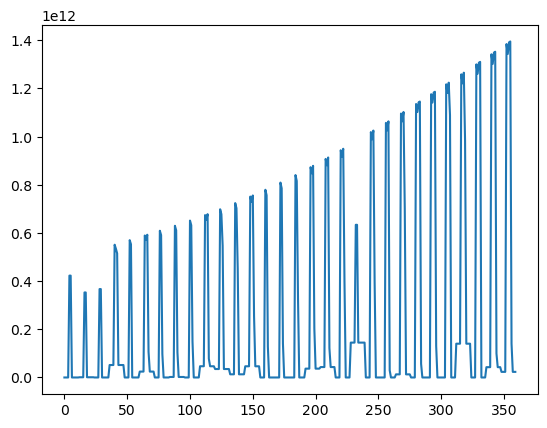

In [34]:
plt.plot(sim_monthly_kcal_consumed[0,:], label='Alpha for First Nation')

In [49]:
def comprehensive_fbs_verification(nation_name, year_val, show_details=True):
    """
    Comprehensive FBS verification using the fundamental balance equation:
    Production + Imports - Exports ± Stock Variation = Food + Feed + Seed + Processing + Losses + Other Uses + Residuals
    
    Returns detailed breakdown and identifies any imbalances or missing components.
    """
    
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE FBS VERIFICATION: {nation_name} - {year_val}")
    print(f"{'='*80}")
    
    # Initialize totals
    supply_side = {
        'Production': 0,
        'Imports': 0, 
        'Exports': 0,
        'Stock_Variation': 0
    }
    
    utilization_side = {
        'Food': 0,
        'Feed': 0,
        'Seed': 0,
        'Processing': 0,
        'Losses': 0,
        'Other_Uses': 0,
        'Tourist_Consumption': 0,
        'Residuals': 0
    }
    
    item_breakdown = {}
    
    # Get all FBS elements for verification
    fbs_elements = FBS_Cereals_Complete_National['Element'].unique()
    
    if show_details:
        print(f"\nAvailable FBS Elements:")
        for i, elem in enumerate(sorted(fbs_elements), 1):
            print(f"  {i:2d}. {elem}")
    
    print(f"\n{'-'*60}")
    print(f"ITEM-BY-ITEM BREAKDOWN:")
    print(f"{'-'*60}")
    
    # Process each canonical cereal item
    for canonical_item in CANONICAL_CEREALS:
        item_data = {}
        
        # Supply side components
        production = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Production', fbs_to_canonical_mapping)
        imports = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Import quantity', fbs_to_canonical_mapping)
        exports = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Export quantity', fbs_to_canonical_mapping)
        stock_var = -1*get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Stock Variation', fbs_to_canonical_mapping)
        
        # Utilization side components
        food = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Food', fbs_to_canonical_mapping)
        feed = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Feed', fbs_to_canonical_mapping)
        seed = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Seed', fbs_to_canonical_mapping)
        processing = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Processing', fbs_to_canonical_mapping)
        losses = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Losses', fbs_to_canonical_mapping)
        other_uses = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Other uses (non-food)', fbs_to_canonical_mapping)
        
        # Check for additional elements that might exist
        tourist_cons = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Tourist consumption', fbs_to_canonical_mapping)
        residuals = get_fbs_value(FBS_Cereals_Complete_National, nation_name, year_val, canonical_item, 'Residuals', fbs_to_canonical_mapping)
        
        # Only show items with non-zero values
        if any([production, imports, exports, stock_var, food, feed, seed, processing, losses, other_uses, tourist_cons, residuals]):
            
            # Calculate balances for this item
            item_supply = production + imports - exports + stock_var
            item_utilization = food + feed + seed + processing + losses + other_uses + tourist_cons + residuals
            item_balance = item_supply - item_utilization
            
            # Store item data
            item_data = {
                'supply': {'production': production, 'imports': imports, 'exports': exports, 'stock_var': stock_var},
                'utilization': {'food': food, 'feed': feed, 'seed': seed, 'processing': processing, 
                              'losses': losses, 'other_uses': other_uses, 'tourist_cons': tourist_cons, 'residuals': residuals},
                'net_supply': item_supply,
                'total_utilization': item_utilization,
                'balance': item_balance
            }
            
            item_breakdown[canonical_item] = item_data
            
            if show_details:
                print(f"\n{canonical_item}:")
                print(f"  Supply:      {item_supply:>12,.0f} tons (P:{production:,.0f} + I:{imports:,.0f} - E:{exports:,.0f} ± S:{stock_var:+,.0f})")
                print(f"  Utilization: {item_utilization:>12,.0f} tons (F:{food:,.0f} + Feed:{feed:,.0f} + Seed:{seed:,.0f} + Proc:{processing:,.0f} + Loss:{losses:,.0f} + Other:{other_uses:,.0f})")
                if tourist_cons != 0 or residuals != 0:
                    print(f"               {'':>12s}      (Tourist:{tourist_cons:,.0f} + Residuals:{residuals:+,.0f})")
                print(f"  Balance:     {item_balance:>12,.0f} tons {'✓' if abs(item_balance) < 1 else '✗'}")
            
            # Add to totals
            supply_side['Production'] += production
            supply_side['Imports'] += imports
            supply_side['Exports'] += exports
            supply_side['Stock_Variation'] += stock_var
            
            utilization_side['Food'] += food
            utilization_side['Feed'] += feed
            utilization_side['Seed'] += seed
            utilization_side['Processing'] += processing
            utilization_side['Losses'] += losses
            utilization_side['Other_Uses'] += other_uses
            utilization_side['Tourist_Consumption'] += tourist_cons
            utilization_side['Residuals'] += residuals
    
    # Calculate overall balance
    total_supply = supply_side['Production'] + supply_side['Imports'] - supply_side['Exports'] + supply_side['Stock_Variation']
    total_utilization = sum(utilization_side.values())
    overall_balance = total_supply - total_utilization
    
    print(f"\n{'-'*60}")
    print(f"OVERALL BALANCE SUMMARY:")
    print(f"{'-'*60}")
    
    print(f"\nSUPPLY SIDE:")
    print(f"  Production:      {supply_side['Production']:>12,.0f} tons")
    print(f"  Imports:         {supply_side['Imports']:>12,.0f} tons")
    print(f"  Exports:        -{supply_side['Exports']:>12,.0f} tons")
    print(f"  Stock Variation: {supply_side['Stock_Variation']:>+12,.0f} tons")
    print(f"  Total Supply:    {total_supply:>12,.0f} tons")
    
    print(f"\nUTILIZATION SIDE:")
    print(f"  Food:            {utilization_side['Food']:>12,.0f} tons")
    print(f"  Feed:            {utilization_side['Feed']:>12,.0f} tons")
    print(f"  Seed:            {utilization_side['Seed']:>12,.0f} tons")
    print(f"  Processing:      {utilization_side['Processing']:>12,.0f} tons")
    print(f"  Losses:          {utilization_side['Losses']:>12,.0f} tons")
    print(f"  Other Uses:      {utilization_side['Other_Uses']:>12,.0f} tons")
    if utilization_side['Tourist_Consumption'] != 0:
        print(f"  Tourist Cons:    {utilization_side['Tourist_Consumption']:>12,.0f} tons")
    if utilization_side['Residuals'] != 0:
        print(f"  Residuals:       {utilization_side['Residuals']:>12,.0f} tons")
    print(f"  Total Util:      {total_utilization:>12,.0f} tons")
    
    print(f"\nBALANCE CHECK:")
    print(f"  Difference:      {overall_balance:>12,.0f} tons")
    
    # Determine status
    if abs(overall_balance) < 1:
        status = "✓ PERFECTLY BALANCED"
        color_code = ""
    elif abs(overall_balance) < 1000:
        status = "~ APPROXIMATELY BALANCED"
        color_code = ""
    else:
        balance_pct = (overall_balance / total_supply * 100) if total_supply != 0 else float('inf')
        status = f"✗ IMBALANCED ({balance_pct:+.2f}%)"
        color_code = ""
    
    print(f"  Status:          {status}")
    
    # Additional diagnostics
    if abs(overall_balance) >= 1:
        print(f"\nDIAGNOSTICS:")
        
        # Check for missing data
        if total_supply == 0:
            print("  ⚠ WARNING: Total supply is zero - check production and trade data")
        if total_utilization == 0:
            print("  ⚠ WARNING: Total utilization is zero - check consumption data")
        
        # Check for unusual patterns
        if utilization_side['Feed'] > supply_side['Production']:
            print("  ⚠ NOTE: Feed use exceeds production - high import dependence for feed")
        
        if abs(supply_side['Stock_Variation']) > 0.1 * supply_side['Production']:
            print("  ⚠ NOTE: Large stock variation relative to production")
        
        # Suggest potential issues
        if overall_balance > 1000:
            print("  → Positive balance suggests missing utilization categories or overestimated supply")
        elif overall_balance < -1000:
            print("  → Negative balance suggests missing supply sources or overestimated utilization")
    
    # Return structured data for further analysis
    verification_results = {
        'nation': nation_name,
        'year': year_val,
        'supply_total': total_supply,
        'utilization_total': total_utilization,
        'balance': overall_balance,
        'is_balanced': abs(overall_balance) < 1,
        'supply_breakdown': supply_side,
        'utilization_breakdown': utilization_side,
        'item_breakdown': item_breakdown
    }
    
    return verification_results

# Test the comprehensive verification
results_angola_2022 = comprehensive_fbs_verification('Angola', 2022, show_details=True)

# Test another year for comparison
print("\n" + "="*100)
results_angola_2020 = comprehensive_fbs_verification('Angola', 2020, show_details=False)


COMPREHENSIVE FBS VERIFICATION: Angola - 2022

Available FBS Elements:
   1. Domestic supply quantity
   2. Export quantity
   3. Feed
   4. Food
   5. Food supply (kcal)
   6. Food supply (kcal/capita/day)
   7. Food supply quantity (kg/capita/yr)
   8. Import quantity
   9. Losses
  10. Other uses (non-food)
  11. Processing
  12. Production
  13. Residuals
  14. Seed
  15. Stock Variation
  16. Tourist consumption

------------------------------------------------------------
ITEM-BY-ITEM BREAKDOWN:
------------------------------------------------------------

Rice:
  Supply:               826 tons (P:11 + I:816 - E:1 ± S:-0)
  Utilization:          826 tons (F:719 + Feed:106 + Seed:1 + Proc:0 + Loss:1 + Other:0)
                                 (Tourist:0 + Residuals:-1)
  Balance:                0 tons ✓

Maize:
  Supply:             3,362 tons (P:3,090 + I:211 - E:1 ± S:+62)
  Utilization:        3,361 tons (F:1,673 + Feed:1,402 + Seed:83 + Proc:48 + Loss:154 + Other:1)
  Balance

Angola: Correlation between model and FBS = 0.892
  Model mean: 744.8 kcal/cap/day
  FBS mean: 647.2 kcal/cap/day


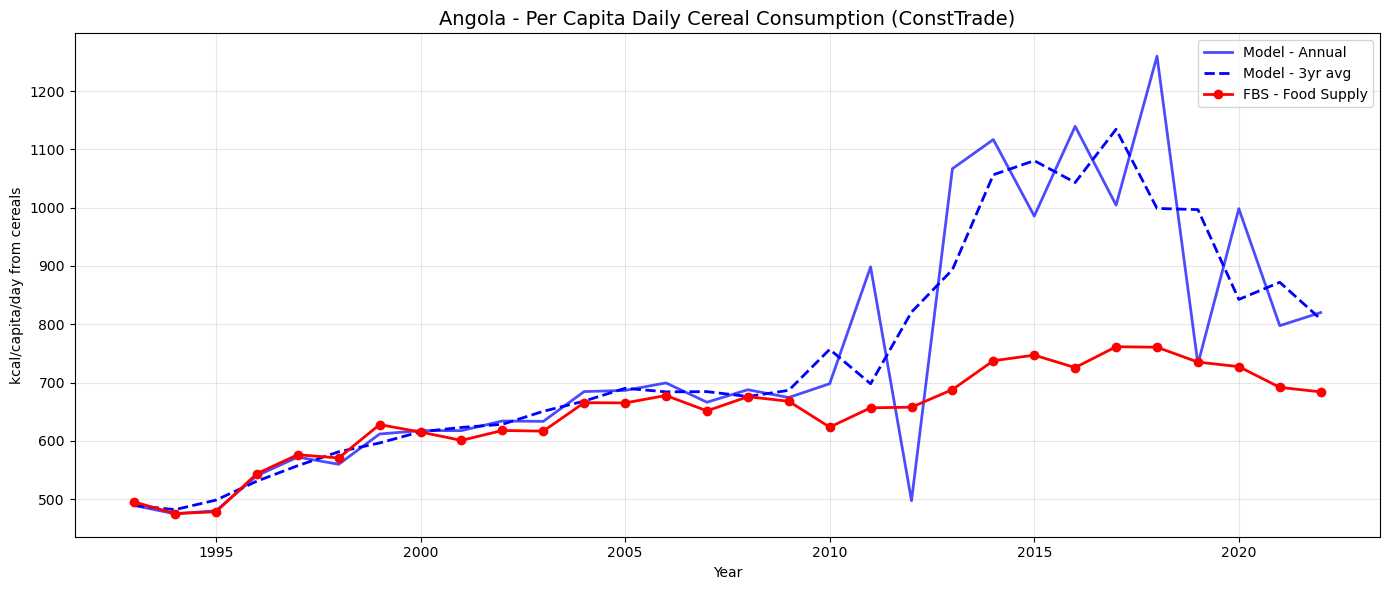

In [52]:
# Plot per capita consumption from the model for the ConstTrade experiment alongside FBS data

if 'seasonal_results_monthly_dict_new' in locals() and 'ConstTrade' in seasonal_results_monthly_dict_new:
    fig, axes = plt.subplots(len(target_nations_monthly_sim), 1, figsize=(14, 6 * len(target_nations_monthly_sim)))
    if len(target_nations_monthly_sim) == 1:
        axes = [axes]  # Ensure iterable for single country
    
    for r_idx, nation_name in enumerate(target_nations_monthly_sim):
        ax = axes[r_idx]
        
        # Get model consumption data (kcal consumed per month)
        model_consumption = seasonal_results_monthly_dict_new['VariedTrade']['NationalMonthlyKcalConsumed'][r_idx, :]
        
        # Convert to yearly consumption and then per capita daily
        yearly_consumption_model = []
        yearly_consumption_model_3yr = []
        model_years = []
        
        for i, year in enumerate(national_years_monthly_sim):
            # Sum 12 months for this year
            year_start_idx = i * 12
            year_end_idx = (i + 1) * 12
            yearly_kcal = model_consumption[year_start_idx:year_end_idx].sum()
            
            # Get population for this year
            pop_data = National_Populations_Data[
                (National_Populations_Data.Year == year) & 
                (National_Populations_Data.Area == nation_name) & 
                (National_Populations_Data.Element == 'Total Population - Both sexes')
            ]
            
            if not pop_data.empty:
                pop_thousands = pop_data.Value.iloc[0]  # Population in thousands
                pop_actual = pop_thousands * 1000  # Convert to actual population
                
                # Calculate per capita daily consumption from cereals
                per_capita_daily_kcal = yearly_kcal / (pop_actual * 365) if pop_actual > 0 else 0
                yearly_consumption_model.append(per_capita_daily_kcal)
                model_years.append(year)
        
        # Calculate 3-year running average
        yearly_consumption_model_3yr = []
        for i in range(len(yearly_consumption_model)):
            if i == 0:
                avg_val = yearly_consumption_model[i]
            elif i == 1:
                avg_val = np.mean(yearly_consumption_model[i-1:i+1])
            else:
                start_idx = max(0, i-1)
                end_idx = min(len(yearly_consumption_model), i+2)
                avg_val = np.mean(yearly_consumption_model[start_idx:end_idx])
            yearly_consumption_model_3yr.append(avg_val)
        
        # Get FBS consumption data for comparison
        fbs_consumption_per_capita = []
        fbs_years = []
        
        for year in national_years_monthly_sim:
            # Get FBS food supply in kcal/capita/day for cereals
            fbs_food_supply = FBS_Cereals_Complete_National[
                (FBS_Cereals_Complete_National.Area == nation_name) & 
                (FBS_Cereals_Complete_National.Year == year) & 
                (FBS_Cereals_Complete_National.Element == "Food supply (kcal/capita/day)")
            ]
            
            if not fbs_food_supply.empty:
                total_fbs_kcal_per_capita_day = fbs_food_supply.Value.sum()
                fbs_consumption_per_capita.append(total_fbs_kcal_per_capita_day)
                fbs_years.append(year)
        
        # Plot the data
        if model_years:
            ax.plot(model_years, yearly_consumption_model, 'b-', label='Model - Annual', alpha=0.7, linewidth=2)
            ax.plot(model_years, yearly_consumption_model_3yr, 'b--', label='Model - 3yr avg', linewidth=2)
        
        if fbs_years:
            ax.plot(fbs_years, fbs_consumption_per_capita, 'r-', label='FBS - Food Supply', linewidth=2, marker='o')
        
        ax.set_title(f'{nation_name} - Per Capita Daily Cereal Consumption (ConstTrade)', fontsize=14)
        ax.set_xlabel('Year')
        ax.set_ylabel('kcal/capita/day from cereals')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Print some statistics
        if model_years and fbs_years:
            # Find overlapping years for correlation
            common_years = list(set(model_years) & set(fbs_years))
            if len(common_years) > 3:
                model_vals = [yearly_consumption_model_3yr[model_years.index(yr)] for yr in common_years if yr in model_years]
                fbs_vals = [fbs_consumption_per_capita[fbs_years.index(yr)] for yr in common_years if yr in fbs_years]
                
                if len(model_vals) == len(fbs_vals) and len(model_vals) > 0:
                    correlation = np.corrcoef(model_vals, fbs_vals)[0,1]
                    print(f"{nation_name}: Correlation between model and FBS = {correlation:.3f}")
                    print(f"  Model mean: {np.mean(model_vals):.1f} kcal/cap/day")
                    print(f"  FBS mean: {np.mean(fbs_vals):.1f} kcal/cap/day")
    
    plt.tight_layout()
    plt.show()
else:
    print("ConstTrade experiment data not available for plotting")

Monthly Alpha Statistics for: Angola - ConstTrade
           Mean   Std Dev       Min       Max  Sample Count
month                                                      
1      0.352787  0.098454  0.155117  0.596144            30
2      0.385929  0.106632  0.171251  0.635180            30
3      0.350686  0.097823  0.154242  0.592269            30
4      0.361300  0.100761  0.158935  0.610029            30
5      0.995308  0.017856  0.929314  1.000000            30
6      0.997194  0.010678  0.957611  1.000000            30
7      0.899749  0.231925  0.236132  1.000000            30
8      0.762024  0.335748  0.152097  1.000000            30
9      0.654643  0.343230  0.156731  1.000000            30
10     0.561668  0.336971  0.151256  1.000000            30
11     0.455747  0.245878  0.155867  1.000000            30
12     0.355764  0.122687  0.150424  0.760504            30


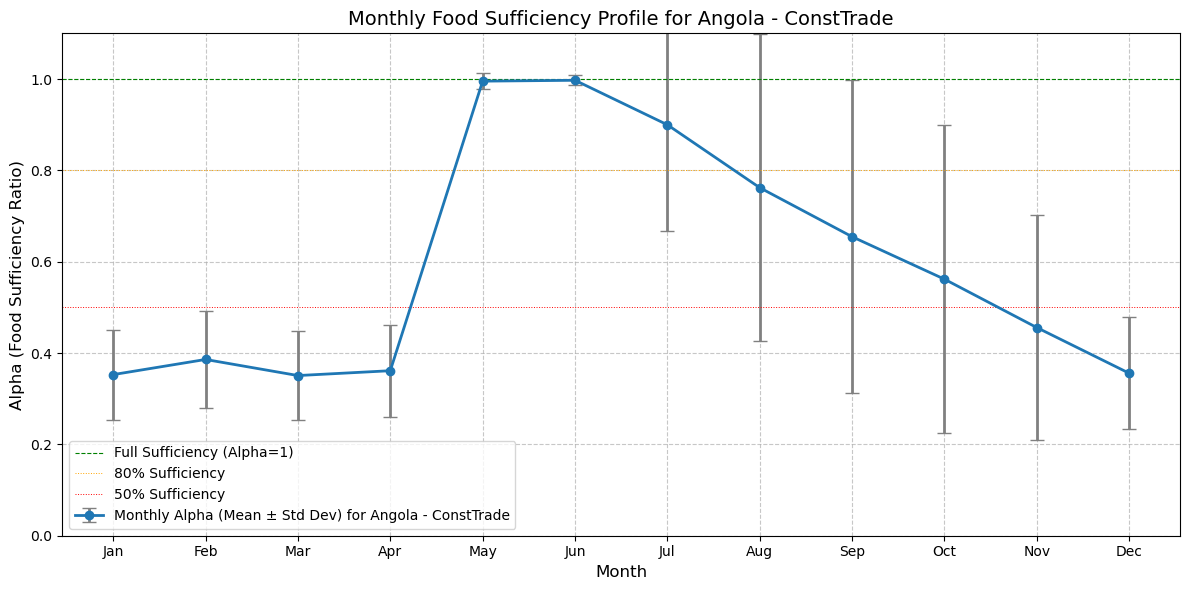

Monthly Alpha Statistics for: Angola - VariedTrade
           Mean   Std Dev       Min      Max  Sample Count
month                                                     
1      0.388133  0.230898  0.066758  1.00000            30
2      0.327759  0.132343  0.000000  0.63518            30
3      0.355849  0.195319  0.036776  1.00000            30
4      0.408180  0.218148  0.138538  1.00000            30
5      0.995308  0.017856  0.929314  1.00000            30
6      0.997194  0.010678  0.957611  1.00000            30
7      0.899749  0.231925  0.236132  1.00000            30
8      0.762024  0.335748  0.152097  1.00000            30
9      0.654643  0.343230  0.156731  1.00000            30
10     0.520036  0.301114  0.151256  1.00000            30
11     0.419986  0.240781  0.000000  1.00000            30
12     0.404671  0.233687  0.033601  1.00000            30


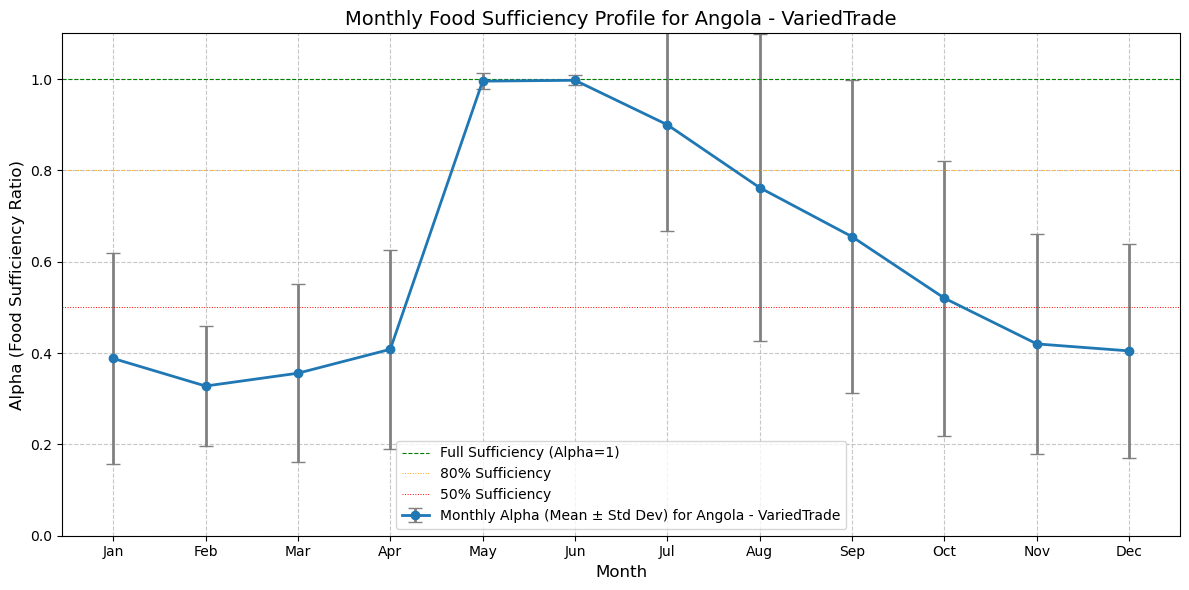

Monthly Alpha Statistics for: Angola - NoTrade
           Mean   Std Dev       Min       Max  Sample Count
month                                                      
1      0.025271  0.038972  0.000000  0.149548            30
2      0.027557  0.042184  0.000000  0.159341            30
3      0.025119  0.038736  0.000000  0.148577            30
4      0.025879  0.039905  0.000000  0.153032            30
5      0.962296  0.101913  0.646401  1.000000            30
6      0.965200  0.094994  0.665799  1.000000            30
7      0.658350  0.422797  0.000000  1.000000            30
8      0.314433  0.389957  0.000000  1.000000            30
9      0.035308  0.044556  0.000000  0.150593            30
10     0.024603  0.037929  0.000000  0.145272            30
11     0.025349  0.039077  0.000000  0.149639            30
12     0.024460  0.037704  0.000000  0.144355            30


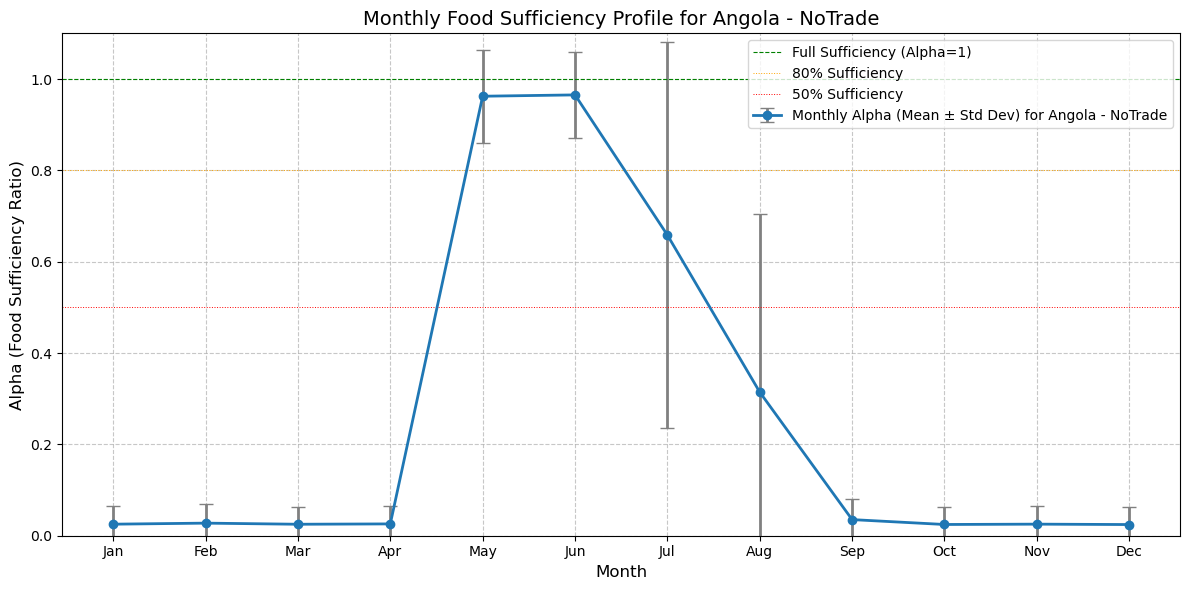

In [37]:
# Create seasonal profile plots for alpha from the new monthly model
if 'seasonal_results_monthly_dict_new' in locals() and target_nations_monthly_sim:
    for experiment_name in ['ConstTrade', 'VariedTrade', 'NoTrade']:
        if experiment_name in seasonal_results_monthly_dict_new:
            alpha_data = seasonal_results_monthly_dict_new[experiment_name]['NationalAlpha']
            
            for r_idx, nation_name in enumerate(target_nations_monthly_sim):
                # Reshape alpha data to have years as rows and months as columns
                alpha_reshaped = alpha_data[r_idx, :].reshape(len(national_years_monthly_sim), 12)
                
                # Create monthly time series with month index (1-12)
                monthly_series = pd.Series(alpha_data[r_idx, :])
                monthly_series.index = pd.MultiIndex.from_arrays([
                    np.repeat(national_years_monthly_sim, 12),
                    np.tile(range(1, 13), len(national_years_monthly_sim))
                ], names=['year', 'month'])
                
                # Call the seasonal_profile function
                seasonal_profile(monthly_series, f"{nation_name} - {experiment_name}")

In [ ]:

# %%
cereal_caloric_density_monthly_param = 2609 * 1000; caloric_requirement_monthly_param = 1240 * 365 / 12
experiments_monthly_list = ["VariedTrade", "ConstTrade", "StockDepreciation", "NoTrade"]
seasonal_results_monthly_dict = {exp: {} for exp in experiments_monthly_list}

national_years_monthly_setup = FBS_Cereals_Complete_National.Year.unique()
national_years_monthly_sim = national_years_monthly_setup[-(30 if len(national_years_monthly_setup) >=30 else len(national_years_monthly_setup)):] # Ensure we don't go out of bounds
target_nations_monthly_list = ['Senegal', 'Burkina Faso', 'Angola']
target_nations_monthly_sim = [n_mon for n_mon in target_nations_monthly_list if n_mon in FBS_Cereals_Complete_National.Area.unique() and n_mon in National_Populations_Data.Area.unique() and n_mon in National_Crop_Calendar_Data.name0_shr.unique() and n_mon in Combined_Monthly_Trade_Data.reporterDesc.unique()]

if not target_nations_monthly_sim: print("Warning: No target nations for monthly simulation after filtering. Check data.")

for experiment_name_mon in experiments_monthly_list:
    num_time_steps_mon = len(national_years_monthly_sim) * 12
    sim_stocks_monthly_arr = np.zeros((len(target_nations_monthly_sim), num_time_steps_mon))
    sim_alpha_monthly_arr = np.ones((len(target_nations_monthly_sim), num_time_steps_mon))
    print(f"Running Monthly Experiment: {experiment_name_mon}")

    for r_idx_mon, nation_name_monthly_sim in enumerate(target_nations_monthly_sim):
        seed_monthly_param, loss_monthly_param = 0.03, 0.04
        # sim_stocks_monthly_arr[r_idx_mon, 0] = 0.01 # Initial stock for t=0

        for i_idx_mon, year_val_monthly_sim in enumerate(national_years_monthly_sim):
            #
            
            for month_idx_mon in np.arange(12):
                current_sim_step_mon = 12 * i_idx_mon + month_idx_mon
                processing_monthly_param, economic_use_monthly_param, residuals_monthly_param = 0,0,0
                
                pop_start_series_mon = National_Populations_Data[(National_Populations_Data.Year == year_val_monthly_sim) & (National_Populations_Data.Area == nation_name_monthly_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
                next_year_val = year_val_monthly_sim + 1
                max_pop_year = National_Populations_Data.Year.max()
                if next_year_val > max_pop_year: next_year_val = max_pop_year # Cap to max available year
                
                pop_end_series_mon = National_Populations_Data[(National_Populations_Data.Year == next_year_val) & (National_Populations_Data.Area == nation_name_monthly_sim) & (National_Populations_Data.Element == 'Total Population - Both sexes')].Value
                if pop_end_series_mon.empty: pop_end_series_mon = pop_start_series_mon # Use current if next year's data is missing
                
                Pop_val_monthly_sim = 0
                if not pop_start_series_mon.empty and not pop_end_series_mon.empty:
                     Pop_val_monthly_sim = 1000 * (pop_start_series_mon.values[0] + (month_idx_mon / 12.0) * (pop_end_series_mon.values[0] - pop_start_series_mon.values[0]))
                elif not pop_start_series_mon.empty: Pop_val_monthly_sim = 1000 * pop_start_series_mon.values[0]
                #todo: priority 0... below, shuold work just having replaced FBS_Cerals...with FBS_CerealsRoots
                Y_val_monthly_sim = 0
                annual_production_items_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_monthly_sim) & (FBS_Cereals_Complete_National.Element == 'Production') & (FBS_Cereals_Complete_National.Area == nation_name_monthly_sim)]
                for _, item_row_mon in annual_production_items_mon.iterrows():
                    cereal_item_name_mon, annual_prod_value_mon = item_row_mon['Item'], item_row_mon['Value']
                    crop_short_name_mon = cereal_item_name_mon.split(' ')[0]
                    harvest_percentage_mon = 1/12
                    calendar_entry_mon = National_Crop_Calendar_Data[(National_Crop_Calendar_Data.name0_shr == nation_name_monthly_sim) & (National_Crop_Calendar_Data.crop_name == crop_short_name_mon)]
                    if not calendar_entry_mon.empty: harvest_percentage_mon = calendar_entry_mon.monthly_harvest_proportions.iloc[0][month_idx_mon]
                    Y_val_monthly_sim += 1000 * harvest_percentage_mon * annual_prod_value_mon
                
                annual_imports_fbs_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_monthly_sim)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == nation_name_monthly_sim)]["Value"].sum() * 1000
                annual_exports_fbs_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_monthly_sim)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == nation_name_monthly_sim)]["Value"].sum() * 1000
                imports_prop_mon, exports_prop_mon = 1/12, 1/12

                if experiment_name_mon == "VariedTrade":
                    monthly_trade_nation_year_mon = Combined_Monthly_Trade_Data[(Combined_Monthly_Trade_Data.reporterDesc == nation_name_monthly_sim) & (Combined_Monthly_Trade_Data.refYear == year_val_monthly_sim)]
                    if not monthly_trade_nation_year_mon.empty:
                        imports_month_val_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Import") & (monthly_trade_nation_year_mon.partnerDesc == "World") & (monthly_trade_nation_year_mon.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000
                        exports_month_val_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Export") & (monthly_trade_nation_year_mon.partnerDesc == "World") & (monthly_trade_nation_year_mon.refMonth == month_idx_mon + 1)].netWgt.sum() / 1000
                        imports_year_total_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Import") & (monthly_trade_nation_year_mon.partnerDesc == "World")].netWgt.sum() / 1000
                        exports_year_total_mon = monthly_trade_nation_year_mon[(monthly_trade_nation_year_mon.flowDesc == "Export") & (monthly_trade_nation_year_mon.partnerDesc == "World")].netWgt.sum() / 1000
                        imports_prop_mon = imports_month_val_mon / imports_year_total_mon if imports_year_total_mon != 0 else (1/12 if imports_month_val_mon > 0 else 0)
                        exports_prop_mon = exports_month_val_mon / exports_year_total_mon if exports_year_total_mon != 0 else (1/12 if exports_month_val_mon > 0 else 0)
                elif experiment_name_mon == "NoTrade": imports_prop_mon, exports_prop_mon = 0,0
                
                trade_balance_val_monthly_sim = (imports_prop_mon * annual_imports_fbs_mon) - (exports_prop_mon * annual_exports_fbs_mon)
                food_demand_monthly_sim = Pop_val_monthly_sim * caloric_requirement_monthly_param / cereal_caloric_density_monthly_param if Pop_val_monthly_sim > 0 else 0
                total_supply_monthly_sim = Y_val_monthly_sim + trade_balance_val_monthly_sim
                food_supply_term_monthly_sim = food_demand_monthly_sim * (1 + processing_monthly_param)
                
                prev_stock_mon = sim_stocks_monthly_arr[r_idx_mon, current_sim_step_mon - 1] if current_sim_step_mon > 0 else 0.01 # Initial stock if t=0
                available_for_food_monthly_sim = prev_stock_mon + trade_balance_val_monthly_sim + Y_val_monthly_sim * (1 - seed_monthly_param - loss_monthly_param) - total_supply_monthly_sim * economic_use_monthly_param

                if food_supply_term_monthly_sim == 0: sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon] = 1
                elif available_for_food_monthly_sim >= food_supply_term_monthly_sim: sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon] = 1
                else: sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon] = np.clip(available_for_food_monthly_sim / food_supply_term_monthly_sim, 0, 1)
                
                # dstock logic:
                dstock_monthly_sim_val = trade_balance_val_monthly_sim + Y_val_monthly_sim*(1-seed_monthly_param-loss_monthly_param) \
                                         - sim_alpha_monthly_arr[r_idx_mon, current_sim_step_mon]*food_demand_monthly_sim \
                                         - total_supply_monthly_sim*(economic_use_monthly_param + processing_monthly_param + residuals_monthly_param)
                current_month_stock_val = prev_stock_mon + dstock_monthly_sim_val
                if experiment_name_mon == "StockDepreciation": current_month_stock_val -= prev_stock_mon * (0.34) 
                sim_stocks_monthly_arr[r_idx_mon, current_sim_step_mon] = current_month_stock_val

    seasonal_results_monthly_dict[experiment_name_mon]["NationalStocks"] = sim_stocks_monthly_arr
    seasonal_results_monthly_dict[experiment_name_mon]["NationalAlpha"] = sim_alpha_monthly_arr

In [ ]:
# todo: priortiy 3 add in gridded model, version 1 (notrade)
# todo: priortiy 4 add in gridded model, version (gravity trade)

# MODEL PLOTTING & FURTHER ANALYSES

## Plotting - 0-D Global Model

In [ ]:

# %%
fig_gm_plot, (ax1_gm_plot, ax2_gm_plot) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Ensure data for plotting is available and aligned
pop_for_plot_gm = Pop_Data_Global[Pop_Data_Global['Year'].isin(global_model_years_gm)]['Value'].values
prod_for_plot_gm = Production_Data_Global[Production_Data_Global['Year'].isin(global_model_years_gm)]['Value'].values
if len(pop_for_plot_gm) == len(global_model_years_gm) and len(prod_for_plot_gm) == len(global_model_years_gm):
    ax1_gm_plot.plot(global_model_years_gm, 1000 * pop_for_plot_gm * caloric_requirement_gm / cereal_caloric_density_gm * (1 + processing_gm_param), 'b--', label='Estimated demand [t]')
    ax1_gm_plot.plot(global_model_years_gm, alpha_gm_sim * 1000 * pop_for_plot_gm * caloric_requirement_gm / cereal_caloric_density_gm * (1 + processing_gm_param), 'r*', label='Model food consumption [t]')
    ax1_gm_plot.plot(global_model_years_gm, prod_for_plot_gm * (1 - seed_gm_param - loss_gm_param - economic_use_gm_ts[0]), label='Supply Available for Food (base econ use) [t]')
    ax1_gm_plot.plot(global_model_years_gm, stocks_gm_sim, label='Model stock level [t]')
    if stocks_obs_gm_aligned:
        ax1_gm_plot.plot(common_years_obs_gm, 1000 * np.array(stocks_obs_gm_aligned) - stocks_obs_gm_aligned[0] * 1000, label='Obs stocks (Diff. from 1st common year) [t]')
else:
    print("Global model plotting skipped due to misaligned data lengths.")

ax1_gm_plot.legend()
ax1_gm_plot.set_ylabel('Tons')
ax1_gm_plot.grid(True)
ax1_gm_plot.set_title('Global Cereals Supply-Utilization Balance')

ax2_gm_plot.plot(global_model_years_gm, alpha_gm_sim, 'g-', label='Alpha (Satisfaction Ratio)')
ax2_gm_plot.legend()
ax2_gm_plot.set_xlabel('Year')
ax2_gm_plot.set_ylabel('Ratio')
ax2_gm_plot.grid(True)
ax2_gm_plot.set_title('Cereals Consumption Gap')
plt.tight_layout()
plt.show()

# %%
# Second plot for Global Model
plt.figure(figsize=(10,6))
if len(pop_for_plot_gm) == len(global_model_years_gm) and len(prod_for_plot_gm) == len(global_model_years_gm):
    plt.plot(global_model_years_gm, 1000*pop_for_plot_gm*caloric_requirement_gm/cereal_caloric_density_gm*(1+processing_gm_param),'b--',label='Estimated demand [t]')
    plt.plot(global_model_years_gm, alpha_gm_sim*1000*pop_for_plot_gm*caloric_requirement_gm/cereal_caloric_density_gm*(1+processing_gm_param),'r*',label='Model food consumption [t]')
    plt.plot(global_model_years_gm, prod_for_plot_gm*(1-seed_gm_param-loss_gm_param-economic_use_gm_ts[0]),label='Supply Available for Food (base econ use) [t]')
    if stocks_obs_gm_aligned:
        plt.plot(global_model_years_gm, stocks_gm_sim + stocks_obs_gm_aligned[0]*1000, label='Model stock level (adjusted by obs start) [t]')
        plt.plot(common_years_obs_gm, 1000*np.array(stocks_obs_gm_aligned),label='Obs stocks [t]')
else:
    print("Second global model plot skipped due to misaligned data lengths.")
plt.legend()
plt.xlabel('Year')
plt.ylabel('Tons')
plt.title('Global Cereals Supply-Utilization Metrics')
plt.grid(True)
plt.show()





## Plotting - 1-D Regional Model


In [ ]:

# %%
# Plotting Mean Proportions from Regional FBS Data
print("\nMean Proportions for Regional Model (Factual FBS - Head):")
if not mean_proportions_reg_fbs.empty:
    print(mean_proportions_reg_fbs.head())
else:
    print("Mean proportions DataFrame for regional FBS is empty.")

# %%
# Plotting Alpha for Regional Model Counterfactual
if 'alpha_reg_cf_sim' in locals() and alpha_reg_cf_sim.size > 0 and valid_regions_for_model_cf: # Check if sim ran
    plt.figure(figsize=(12, 7))
    ax_reg_alpha_plot = plt.subplot(111)
    colors_regional_plot = plt.cm.get_cmap('tab20', len(valid_regions_for_model_cf))
    for r_idx_cf_plot, region_name_cf_plot in enumerate(valid_regions_for_model_cf):
        if alpha_reg_cf_sim[r_idx_cf_plot, :].mean() < 1:
            ax_reg_alpha_plot.plot(regional_model_years_cf[3:], alpha_reg_cf_sim[r_idx_cf_plot, 3:], label=region_name_cf_plot, color=colors_regional_plot(r_idx_cf_plot))
    ax_reg_alpha_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax_reg_alpha_plot.set_xlabel('Year'); ax_reg_alpha_plot.set_ylabel('Alpha (Satisfaction Ratio)')
    ax_reg_alpha_plot.set_title('Regional Cereal Consumption Gap (Counterfactual Model)'); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Regional counterfactual alpha plot skipped - simulation data not available.")

# %%
# Plotting Regional Stocks (Example: Eastern Africa FBS vs Modeled Counterfactual)
if 'stocks_reg_cf_sim' in locals() and stocks_reg_cf_sim.size > 0 and valid_regions_for_model_cf: # Check if sim ran
    plt.figure(figsize=(10, 6))
    target_plot_region_cf = "Eastern Africa"
    if target_plot_region_cf in FAO_FBS_Cereals_Regional.Area.unique():
        fbs_stock_var_target_cf = FAO_FBS_Cereals_Regional[(FAO_FBS_Cereals_Regional.Area == target_plot_region_cf) & (FAO_FBS_Cereals_Regional.Element == "Stock Variation") & (FAO_FBS_Cereals_Regional.Year.isin(regional_model_years_cf))].groupby("Year")["Value"].sum()
        if not fbs_stock_var_target_cf.empty:
            fao_fbs_cumulative_stocks_target_cf = 1000 * np.cumsum(fbs_stock_var_target_cf.values)
            plt.plot(fbs_stock_var_target_cf.index, fao_fbs_cumulative_stocks_target_cf, label=f'FBS Cum. Stock Var. ({target_plot_region_cf}) [tons]')
    if target_plot_region_cf in valid_regions_for_model_cf:
        r_idx_target_cf_plot = valid_regions_for_model_cf.index(target_plot_region_cf)
        plt.plot(regional_model_years_cf, stocks_reg_cf_sim[r_idx_target_cf_plot, :], label=f'Modeled Stocks ({target_plot_region_cf}) [tons]', linestyle='--')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left'); plt.ylabel('Stocks (tons)'); plt.xlabel('Year')
    plt.title(f'Regional Cereal Stocks Comparison ({target_plot_region_cf})'); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Regional counterfactual stock plot skipped - simulation data not available.")


## Plotting - National Model


In [ ]:
POU_National = pd.read_csv(r"C:\Users\danie\Downloads\FAO_POU_NationalWorld.csv")
POU_National["YearAvg"] = [int(POU_National["Year Code"].iloc[i].astype(str)[0:4])+1 for i in range(len(POU_National))] 

array(['Prevalence of undernourishment (percent) (3-year average)',
       'Prevalence of severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of severe food insecurity in the male adult population (percent) (3-year average)',
       'Prevalence of severe food insecurity in the female adult population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the male adult population (percent) (3-year average)',
       'Prevalence of moderate or severe food insecurity in the female adult population (percent) (3-year average)'],
      dtype=object)

In [474]:
FBS_Cereals_Complete_National.Element.unique()

array(['Production', 'Seed', 'Import quantity',
       'Domestic supply quantity', 'Food supply (kcal/capita/day)',
       'Food', 'Losses', 'Food supply quantity (kg/capita/yr)', 'Feed',
       'Export quantity', 'Stock Variation', 'Processing',
       'Other uses (non-food)', 'Residuals', 'Food supply (kcal)',
       'Tourist consumption'], dtype=object)

In [476]:
FBS_Cereals_Complete_National.Element.unique()

array(['Production', 'Seed', 'Import quantity',
       'Domestic supply quantity', 'Food supply (kcal/capita/day)',
       'Food', 'Losses', 'Food supply quantity (kg/capita/yr)', 'Feed',
       'Export quantity', 'Stock Variation', 'Processing',
       'Other uses (non-food)', 'Residuals', 'Food supply (kcal)',
       'Tourist consumption'], dtype=object)

In [483]:
FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Area == nation_name_nat_plot) & (FBS_Cereals_Complete_National.Element == "Food supply (kcal/capita/day)")]
                
            

,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (FBS),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
1004,FBSH,"Food Balances (-2013, old methodology and popu...",716,Zimbabwe,664,Food supply (kcal/capita/day),S2805,Rice (Milled Equivalent),1961,1961,kcal/cap/d,4.10,E,Estimated value,NaN
1100,FBSH,"Food Balances (-2013, old methodology and popu...",716,Zimbabwe,664,Food supply (kcal/capita/day),S2511,Wheat and products,1961,1961,kcal/cap/d,161.31,E,Estimated value,NaN
3112,FBSH,"Food Balances (-2013, old methodology and popu...",716,Zimbabwe,664,Food supply (kcal/capita/day),S2517,Millet and products,1961,1961,kcal/cap/d,293.27,E,Estimated value,NaN
3160,FBSH,"Food Balances (-2013, old methodology and popu...",716,Zimbabwe,664,Food supply (kcal/capita/day),S2520,"Cereals, Other",1961,1961,kcal/cap/d,0.00,E,Estimated value,NaN
3185,FBSH,"Food Balances (-2013, old methodology and popu...",716,Zimbabwe,664,Food supply (kcal/capita/day),S2514,Maize and products,1961,1961,kcal/cap/d,976.89,E,Estimated value,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233623,FBS,Food Balances (2010-),716,Zimbabwe,664,Food supply (kcal/capita/day),S2807,Rice and products,2022,2022,kcal/cap/d,106.89,E,Estimated value,NaN
233638,FBS,Food Balances (2010-),716,Zimbabwe,664,Food supply (kcal/capita/day),S2516,Oats,2022,2022,kcal/cap/d,0.18,E,Estimated value,NaN
233773,FBS,Food Balances (2010-),716,Zimbabwe,664,Food supply (kcal/capita/day),S2514,Maize and products,2022,2022,kcal/cap/d,638.61,E,Estimated value,NaN
233806,FBS,Food Balances (2010-),716,Zimbabwe,664,Food supply (kcal/capita/day),S2518,Sorghum and products,2022,2022,kcal/cap/d,25.59,E,Estimated value,NaN


In [ ]:
# Plotting Alpha for National Model Simulation
plt.figure(figsize=(12, 7))
ax_nat_alpha_plot = plt.subplot(111)
corrs = []
# colors_national_plot = plt.cm.get_cmap('tab10', len(target_nations_nat_sim)) # Ensure enough colors if needed
for r_idx_nat_plot, nation_name_nat_plot in enumerate(target_nations_nat_sim[:]):
    if national_alpha_sim_nat[r_idx_nat_plot, :].mean() < 1.1: # Condition from original
        #if nation_name_nat_plot == 'Senegal': # Special case for Tanzania
            smoothed_val = np.convolve(national_alpha_sim_nat[r_idx_nat_plot, :], np.ones(4)/4, mode='same') # Smoothing for better visualization
            ax_nat_alpha_plot.plot(national_model_years_nat[8:-1], 100*smoothed_val[8:-1], label=nation_name_nat_plot) # color=colors_national_plot(r_idx_nat_plot)
            pou_item  = 'Prevalence of moderate or severe food insecurity in the total population (percent) (3-year average)'
            pou_item  = 'Prevalence of undernourishment (percent) (3-year average)'
            yr = POU_National[(POU_National.Area == nation_name_nat_plot) & (POU_National.Item == pou_item)].YearAvg.values
            #val = np.array([float(POU_National[(POU_National.Area == nation_name_nat_plot) & (POU_National.Item == pou_item)].Value.values[i]) if POU_National[(POU_National.Area == nation_name_nat_plot) & (POU_National.Item == pou_item)].Value.values[i] != '<2.5' else 0 for i in range(len(POU_National[(POU_National.Area == nation_name_nat_plot) & (POU_National.Item == pou_item)]))]) # Convert to float, handle empty strings
            val = np.array([float(FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Area == nation_name_nat_plot) & (FBS_Cereals_Complete_National.Element == "Food supply (kcal/capita/day)")].groupby("Year").sum().Value.values[i]) for i in range(len(POU_National[(POU_National.Area == nation_name_nat_plot) & (POU_National.Item == pou_item)]))]) # Convert to float, handle empty strings
            
            # Convert to float, handle empty strings
            print(np.corrcoef(val[:-1],smoothed_val[8:-1])[0,1])
            corrs.append(np.corrcoef(val[:-1],smoothed_val[8:-1])[0,1])
            plt.plot(yr[:-1],val[:-1],label='POU'+nation_name_nat_plot, linestyle='--')
ax_nat_alpha_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax_nat_alpha_plot.set_xlabel('Year')
ax_nat_alpha_plot.set_ylabel('Alpha (Satisfaction Ratio)')
ax_nat_alpha_plot.set_title('National Cereal Consumption Gap (Simulated)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [469]:
# Create a sorted list of correlations with corresponding nation names
sorted_indices = np.argsort(corrs)
sorted_corrs = np.array(corrs)[sorted_indices]
sorted_nations = np.array(target_nations_nat_sim)[sorted_indices]

print("Sorted Correlations and Nation Names:")
print("=" * 50)
#for region, data in regional_food_supply_ratios.items():
    #if (region == "Western Africa") or (region == "Eastern Africa") or (region == "Middle Africa") or (region == "Northern America"):
    #if region == "Zimbabwe":
        #print(f"\n{region}:")
        #print(f"Years: {data['Year'].min()} - {data['Year'].max()}")
        #print(f"Mean ratio: {data['Food_Supply_Ratio'].mean():.3f}")
for i, (corr, nation) in enumerate(zip(sorted_corrs, sorted_nations)):
    Variability = regional_food_supply_ratios[nation].Food_Supply_Ratio.mean()
    print(f"{i+1:2d}. {nation:30s} : {corr:6.3f}", f" | Food Use Var.: {Variability:.3f}" )

Sorted Correlations and Nation Names:
 1. Mali                           : -0.942  | Food Use Var.: 0.704
 2. Djibouti                       : -0.924  | Food Use Var.: 0.767
 3. Zambia                         : -0.908  | Food Use Var.: 0.865
 4. Guinea                         : -0.906  | Food Use Var.: 0.663
 5. Cameroon                       : -0.888  | Food Use Var.: 0.765
 6. United Republic of Tanzania    : -0.876  | Food Use Var.: 0.719
 7. Sierra Leone                   : -0.844  | Food Use Var.: 0.823
 8. Uganda                         : -0.831  | Food Use Var.: 0.606
 9. Nigeria                        : -0.777  | Food Use Var.: 0.719
10. Gabon                          : -0.766  | Food Use Var.: 0.778
11. Senegal                        : -0.655  | Food Use Var.: 0.801
12. Guinea-Bissau                  : -0.636  | Food Use Var.: 0.868
13. Madagascar                     : -0.631  | Food Use Var.: 0.758
14. Chad                           : -0.598  | Food Use Var.: 0.831
15. Ethiop

## Plotting - National Monthly Model


In [ ]:

# %%
# Plotting Alpha for National Monthly Model Experiments
if seasonal_results_monthly_dict and target_nations_monthly_sim and national_years_monthly_sim.size > 0:
    plt.figure(figsize=(14, 8))
    ax_monthly_alpha_plot = plt.subplot(111)
    num_months_total_plot = len(national_years_monthly_sim) * 12
    if num_months_total_plot > 0:
        monthly_time_axis_plot = pd.date_range(start=str(national_years_monthly_sim[0]), periods=num_months_total_plot, freq="M")
        for experiment_name_mon_plot in experiments_monthly_list:
            if experiment_name_mon_plot in seasonal_results_monthly_dict and "NationalAlpha" in seasonal_results_monthly_dict[experiment_name_mon_plot]:
                alpha_data_mon_plot = seasonal_results_monthly_dict[experiment_name_mon_plot]["NationalAlpha"]
                if alpha_data_mon_plot.shape[0] == len(target_nations_monthly_sim) and alpha_data_mon_plot.shape[1] == num_months_total_plot: # Check dimensions
                    for r_idx_mon_plot, nation_name_monthly_plot in enumerate(target_nations_monthly_sim):
                        if alpha_data_mon_plot[r_idx_mon_plot, :].mean() < 1.1 : # Condition to make plot less crowded
                            ax_monthly_alpha_plot.plot(monthly_time_axis_plot, alpha_data_mon_plot[r_idx_mon_plot, :], label=f'{nation_name_monthly_plot} - {experiment_name_mon_plot}', alpha=0.7)
        ax_monthly_alpha_plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
        ax_monthly_alpha_plot.set_xlabel('Month-Year'); ax_monthly_alpha_plot.set_ylabel('Alpha (Satisfaction Ratio)')
        ax_monthly_alpha_plot.set_title('National Monthly Cereal Consumption Gap by Experiment'); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("National monthly alpha plot skipped - simulation data or config not available.")

# %%
# Analysis of Alpha Estimates from Monthly Model (example for first experiment, first nation)
if seasonal_results_monthly_dict and experiments_monthly_list and target_nations_monthly_sim and national_years_monthly_sim.size > 0:
    first_experiment_mon_plot = experiments_monthly_list[0]
    if target_nations_monthly_sim: # Ensure list is not empty
        first_nation_idx_mon_plot = 2
        nation_name_for_title = target_nations_monthly_sim[first_nation_idx_mon_plot]
        plt.figure(figsize=(12,7))
        if first_experiment_mon_plot in seasonal_results_monthly_dict and "NationalAlpha" in seasonal_results_monthly_dict[first_experiment_mon_plot]:
            national_alpha_exp_plot = seasonal_results_monthly_dict[first_experiment_mon_plot]["NationalAlpha"]
            num_years_plot_mon = len(national_years_monthly_sim)
            if national_alpha_exp_plot.shape[0] > first_nation_idx_mon_plot and national_alpha_exp_plot.shape[1] == num_years_plot_mon * 12:
                alpha_max_season = np.array([np.max(national_alpha_exp_plot[first_nation_idx_mon_plot, i*12 : i*12+12]) for i in range(num_years_plot_mon)])
                alpha_min_season = np.array([np.min(national_alpha_exp_plot[first_nation_idx_mon_plot, i*12 : i*12+12]) for i in range(num_years_plot_mon)])
                #alpha_late_season = np.array([np.mean(national_alpha_exp_plot[first_nation_idx_mon_plot, i*12+8 : i*12+12]) for i in range(num_years_plot_mon)])
                alpha_full_year = np.array([np.mean(national_alpha_exp_plot[first_nation_idx_mon_plot, i*12 : i*12+12]) for i in range(num_years_plot_mon)])
                plt.plot(national_years_monthly_sim, alpha_min_season, label="Year Minimum")
                plt.plot(national_years_monthly_sim, alpha_max_season, label="Year Maximum")
                #plt.plot(national_years_monthly_sim, alpha_late_season, label="Late Season (M 9-12)")
                plt.plot(national_years_monthly_sim, alpha_full_year, label="Full Year Avg", linestyle='--')
                plt.ylabel("Alpha Estimate"); plt.xlabel("Year"); plt.legend()
                plt.title(f"{nation_name_for_title} Food Security Alpha Estimates ({first_experiment_mon_plot})"); plt.grid(True); plt.show()
            else: print("Alpha data shape mismatch for seasonal alpha plot.")
        else: print(f"Data for experiment '{first_experiment_mon_plot}' not found in monthly results.")
    else: print("No target nations for monthly seasonal alpha plot.")
else: print("National monthly seasonal alpha plot skipped - data or config not available.")


# %%
# IPC Data Analysis Example (Angola, Jan-May)
ipc_country_plot = 'Angola'; ipc_season_plot = 'Jan-May'
if ipc_country_plot in IPC_Data.adm0_name.unique():
    ipc_subset_plot = IPC_Data[(IPC_Data.adm0_name == ipc_country_plot) & (IPC_Data.chtype == "current") & (IPC_Data.exercise_label == ipc_season_plot)]
    if not ipc_subset_plot.empty:
        ipc_grouped = ipc_subset_plot.groupby("exercise_year")
        ipc_phase3plus_percent = (ipc_grouped["phase3"].sum() + ipc_grouped["phase4"].sum() + ipc_grouped["phase5"].sum()) / ipc_grouped["population"].sum()
        if not ipc_phase3plus_percent.empty:
            plt.figure(figsize=(10,6))
            plt.plot(ipc_phase3plus_percent.index, ipc_phase3plus_percent.values, marker='o', label="IPC Phase 3+ (%)")
            plt.title(f"{ipc_country_plot} IPC Food Security Classifications ({ipc_season_plot})"); plt.xlabel("Year"); plt.ylabel("IPC Phase 3+ (% Total Pop.)")
            plt.legend(); plt.grid(True); plt.show()
    else: print(f"No IPC data for {ipc_country_plot} - {ipc_season_plot} with chtype 'current'.")
else: print(f"IPC data not found for country: {ipc_country_plot}")


In [ ]:
#todo: priority 1: add seasonal profile (with a function)

In [ ]:
#todo: add section for plotting gridded model


## Further Analyses & Miscellaneous Plots


In [ ]:

# %%
# Plotting Monthly Production and Trade Balance (Data derived for plotting purposes)
# This section re-derives monthly production and trade for selected nations for plotting.
# Ensure `national_years_monthly_sim` and `target_nations_monthly_sim` are from the monthly simulation setup.

if target_nations_monthly_sim and national_years_monthly_sim.size > 0:
    monthly_production_for_plot = np.zeros((len(target_nations_monthly_sim), len(national_years_monthly_sim) * 12))
    monthly_trade_balance_for_plot = np.zeros((len(target_nations_monthly_sim), len(national_years_monthly_sim) * 12))

    for r_idx_plot, nation_name_plot_mon in enumerate(target_nations_monthly_sim):
        for i_idx_plot, year_val_plot_mon in enumerate(national_years_monthly_sim):
            for month_idx_plot in np.arange(12):
                current_plot_step_mon = 12 * i_idx_plot + month_idx_plot
                # Monthly Production
                Y_monthly_plot_val = 0
                annual_prod_items_plot = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_plot_mon) & (FBS_Cereals_Complete_National.Element == 'Production') & (FBS_Cereals_Complete_National.Area == nation_name_plot_mon)]
                for _, item_row_plot_mon in annual_prod_items_plot.iterrows():
                    cereal_item_plot, annual_prod_plot = item_row_plot_mon['Item'], item_row_plot_mon['Value']
                    crop_short_plot = cereal_item_plot.split(' ')[0]
                    harvest_perc_plot = 1/12
                    calendar_entry_plot_mon = National_Crop_Calendar_Data[(National_Crop_Calendar_Data.name0_shr == nation_name_plot_mon) & (National_Crop_Calendar_Data.crop_name == crop_short_plot)]
                    if not calendar_entry_plot_mon.empty: harvest_perc_plot = calendar_entry_plot_mon.monthly_harvest_proportions.iloc[0][month_idx_plot]
                    Y_monthly_plot_val += 1000 * harvest_perc_plot * annual_prod_plot
                monthly_production_for_plot[r_idx_plot, current_plot_step_mon] = Y_monthly_plot_val

                # Monthly Trade Balance (using 'VariedTrade' logic for demonstration)
                annual_imports_fbs_plot_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_plot_mon)&(FBS_Cereals_Complete_National.Element =='Import quantity') & (FBS_Cereals_Complete_National.Area == nation_name_plot_mon)]["Value"].sum() * 1000
                annual_exports_fbs_plot_mon = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National.Year == year_val_plot_mon)&(FBS_Cereals_Complete_National.Element =='Export quantity') & (FBS_Cereals_Complete_National.Area == nation_name_plot_mon)]["Value"].sum() * 1000
                imports_prop_plot, exports_prop_plot = 1/12, 1/12
                monthly_trade_nation_year_plot_df = Combined_Monthly_Trade_Data[(Combined_Monthly_Trade_Data.reporterDesc == nation_name_plot_mon) & (Combined_Monthly_Trade_Data.refYear == year_val_plot_mon)]
                if not monthly_trade_nation_year_plot_df.empty:
                    imports_month_plot = monthly_trade_nation_year_plot_df[(monthly_trade_nation_year_plot_df.flowDesc == "Import") & (monthly_trade_nation_year_plot_df.partnerDesc == "World") & (monthly_trade_nation_year_plot_df.refMonth == month_idx_plot + 1)].netWgt.sum() / 1000
                    exports_month_plot = monthly_trade_nation_year_plot_df[(monthly_trade_nation_year_plot_df.flowDesc == "Export") & (monthly_trade_nation_year_plot_df.partnerDesc == "World") & (monthly_trade_nation_year_plot_df.refMonth == month_idx_plot + 1)].netWgt.sum() / 1000
                    imports_year_total_plot_mon = monthly_trade_nation_year_plot_df[(monthly_trade_nation_year_plot_df.flowDesc == "Import") & (monthly_trade_nation_year_plot_df.partnerDesc == "World")].netWgt.sum() / 1000
                    exports_year_total_plot_mon = monthly_trade_nation_year_plot_df[(monthly_trade_nation_year_plot_df.flowDesc == "Export") & (monthly_trade_nation_year_plot_df.partnerDesc == "World")].netWgt.sum() / 1000
                    imports_prop_plot = imports_month_plot / imports_year_total_plot_mon if imports_year_total_plot_mon != 0 else (1/12 if imports_month_plot > 0 else 0)
                    exports_prop_plot = exports_month_plot / exports_year_total_plot_mon if exports_year_total_plot_mon != 0 else (1/12 if exports_month_plot > 0 else 0)
                monthly_trade_balance_for_plot[r_idx_plot, current_plot_step_mon] = (imports_prop_plot * annual_imports_fbs_plot_mon) - (exports_prop_plot * annual_exports_fbs_plot_mon)

    fig_prod_trade_plot, axes_prod_trade_plot = plt.subplots(len(target_nations_monthly_sim), 1, figsize=(12, 4 * len(target_nations_monthly_sim)), sharex=True, sharey=False)
    if len(target_nations_monthly_sim) == 1: axes_prod_trade_plot = [axes_prod_trade_plot] # Ensure iterable
    plot_monthly_time_axis_val = pd.date_range(start=str(national_years_monthly_sim[0]), periods=len(national_years_monthly_sim) * 12, freq="M")
    for r_idx_plot_final, nation_name_plot_final in enumerate(target_nations_monthly_sim):
        ax_pt_plot = axes_prod_trade_plot[r_idx_plot_final]
        ax_pt_plot.plot(plot_monthly_time_axis_val, monthly_production_for_plot[r_idx_plot_final, :] / 1000, label='Monthly Production (kilo tons)', color='blue')
        ax_pt_plot.plot(plot_monthly_time_axis_val, monthly_trade_balance_for_plot[r_idx_plot_final, :] / 1000, label='Monthly Trade Balance (kilo tons)', color='green')
        ax_pt_plot.set_title(f'{nation_name_plot_final} Monthly Cereal Production and Trade Balance'); ax_pt_plot.set_ylabel('Quantity (kilo tons)')
        ax_pt_plot.legend(); ax_pt_plot.grid(True)
    axes_prod_trade_plot[-1].set_xlabel('Month-Year'); plt.tight_layout(); plt.show()
else:
    print("Monthly production/trade plot skipped - data or config not available.")

# %%
# Coefficient of Variation of Caloric Consumption (Example: Senegal)
plot_country_pov_fsi = 'Senegal'
if plot_country_pov_fsi in National_Food_Security_Indicators_Data.Area.unique():
    pov_data_fsi = National_Food_Security_Indicators_Data[(National_Food_Security_Indicators_Data.Area == plot_country_pov_fsi) & (National_Food_Security_Indicators_Data.Item == "Coefficient of variation of habitual caloric consumption distribution (real number)")]
    if not pov_data_fsi.empty:
        pov_year_fsi, pov_val_fsi = pov_data_fsi.Year.astype(int).values, pov_data_fsi.Value.astype(float).values
        plt.figure(figsize=(10,6)); plt.plot(pov_year_fsi, pov_val_fsi, marker='o')
        if pov_year_fsi.size > 0: plt.xlim(pov_year_fsi.min(), pov_year_fsi.max())
        plt.xlabel("Year"); plt.ylabel("Coefficient of Variation")
        plt.title(f"{plot_country_pov_fsi} - Coeff. of Variation of Habitual Caloric Consumption"); plt.grid(True); plt.show()
else: print(f"Data for {plot_country_pov_fsi} not in National_Food_Security_Indicators_Data.")

# %%
# Debug/Verification cell for monthly trade data sums (Original Cell 99) - Kept for reference if needed
# check_region_trade_debug = "Angola" 
# if check_region_trade_debug in Combined_Monthly_Trade_Data.reporterDesc.unique() and \
#    check_region_trade_debug in FBS_Cereals_Complete_National.Area.unique():
#     plt.figure(figsize=(10,6))
#     # ... (Full logic from original cell 99 can be placed here for debugging trade proportions) ...
#     # This involves iterating years, months, summing monthly trade, comparing to annuals.
#     # print(f"Trade debug plot for {check_region_trade_debug} would be generated here.")
#     # plt.show() # If any plot is generated by the debug logic
# else:
#     print(f"Cannot perform trade debug for {check_region_trade_debug}, data missing.")


In [ ]:
FAO_FBS_CerealsTubers_Regional.Item.unique()  # Check available items in the regional tubers data

In [184]:
FBS_Cereals_Complete_National.Item.unique()  # Check available items in the national cereals data

array(['Wheat and products', 'Oats', 'Maize and products',
       'Rice (Milled Equivalent)', 'Cereals, Other',
       'Barley and products', 'Rye and products', 'Sorghum and products',
       'Millet and products', 'Cereals, other', 'Rice and products'],
      dtype=object)

### Food Supply Ratios

Regional Food Supply Ratios (Food/Supply) by Year:

Algeria:
Years: 1961 - 2022
Mean ratio: 0.703
Sample of data:
    Year  Food_Supply_Ratio
52  2013           0.522483
53  2014           0.500654
54  2015           0.467336
55  2016           0.487210
56  2017           0.506569
57  2018           0.471149
58  2019           0.532170
59  2020           0.550239
60  2021           0.631844
61  2022           0.611032

Rwanda:
Years: 1961 - 2022
Mean ratio: 0.770
Sample of data:
    Year  Food_Supply_Ratio
52  2013           0.551127
53  2014           0.651460
54  2015           0.787419
55  2016           0.684943
56  2017           0.692500
57  2018           0.711111
58  2019           0.745404
59  2020           0.757168
60  2021           0.684591
61  2022           0.683731

Mozambique:
Years: 1961 - 2022
Mean ratio: 0.882
Sample of data:
    Year  Food_Supply_Ratio
52  2013           0.987824
53  2014           1.005166
54  2015           0.897849
55  2016           0.926499
56

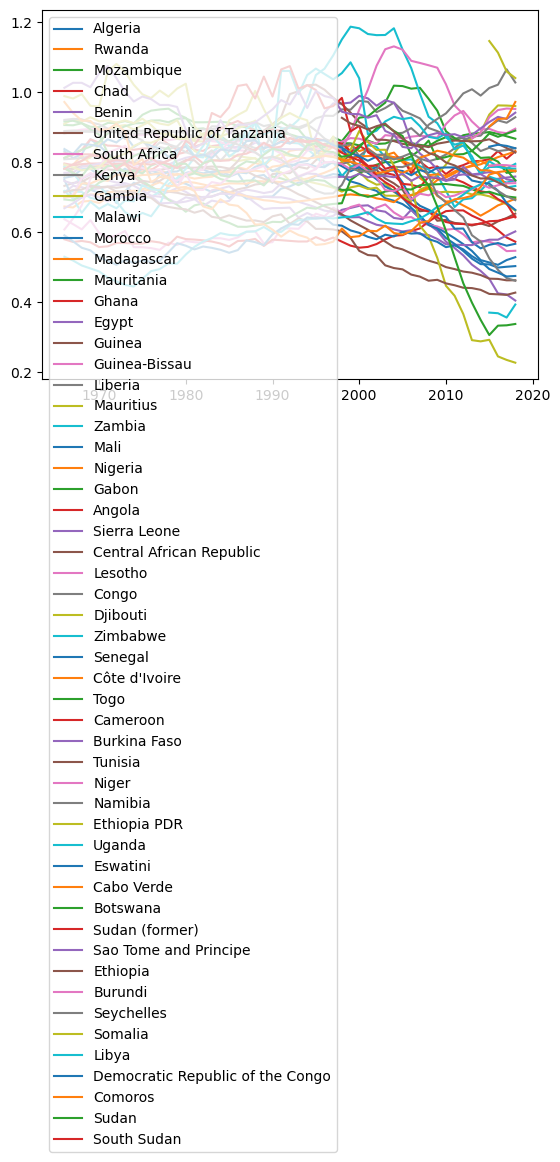

In [402]:
# Calculate Food/(Production+Import quantity-Export quantity) for each region
regional_food_supply_ratios = {}

# Get unique regions from the dataset
unique_regions = FBS_Cereals_Complete_National['Area'].unique()

for region in unique_regions:
    # Filter data for this region
    region_data = FBS_Cereals_Complete_National[(FBS_Cereals_Complete_National['Area'] == region)]#(FBS_Cereals_Complete_National.Item=='Cereals - Excluding Beer')&
    
    # Get unique years for this region
    years = sorted(region_data['Year'].unique())
    
    # Initialize lists to store results
    year_list = []
    ratio_list = []
    
    for year in years:
        year_data = region_data[region_data['Year'] == year]
        
        # Extract values for each component
        food = year_data[year_data['Element'] == 'Food']['Value'].sum()
        production = year_data[year_data['Element'] == 'Production']['Value'].sum()
        imports = year_data[year_data['Element'] == 'Import quantity']['Value'].sum()
        exports = year_data[year_data['Element'] == 'Export quantity']['Value'].sum()
        stock_var = year_data[year_data['Element'] == 'Stock Variation']['Value'].sum() 
        # Calculate denominator (Production + Import quantity - Export quantity)
        denominator = production + imports - exports 
        #print(year)
        # Calculate ratio, avoiding division by zero
        if denominator != 0:
            ratio = food / denominator
            year_list.append(year)
            ratio_list.append(ratio)

    
    # Store results for this region
    if year_list:  # Only store if we have data
        regional_food_supply_ratios[region] = pd.DataFrame({
            'Year': year_list,
            'Food_Supply_Ratio': ratio_list
        })

# Display the results
print("Regional Food Supply Ratios (Food/Supply) by Year:")
print("=" * 60)

for region, data in regional_food_supply_ratios.items():
    #if (region == "Western Africa") or (region == "Eastern Africa") or (region == "Middle Africa") or (region == "Northern America"):
    #if region == "Ghana":
        print(f"\n{region}:")
        print(f"Years: {data['Year'].min()} - {data['Year'].max()}")
        print(f"Mean ratio: {data['Food_Supply_Ratio'].mean():.3f}")
        plt.plot(data['Year'], data['Food_Supply_Ratio'].rolling(window=10,center=True).mean(), label=region)
        plt.legend()
        print(f"Sample of data:")
        print(data.tail(10))


United Republic of Tanzania:
Years: 1961 - 2022
Mean ratio: 0.719
Sample of data:
    Year  Food_Supply_Ratio
52  2013           0.616756
53  2014           0.592859
54  2015           0.635429
55  2016           0.631452
56  2017           0.616537
57  2018           0.660888
58  2019           0.655884
59  2020           0.678606
60  2021           0.684505
61  2022           0.751784


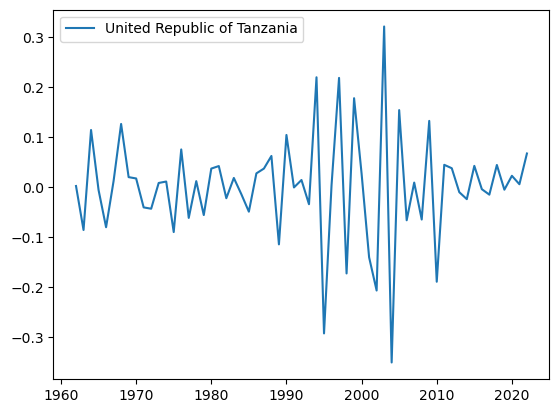

In [188]:
for region, data in regional_food_supply_ratios.items():
    #if (region == "Western Africa") or (region == "Eastern Africa") or (region == "Middle Africa") or (region == "Northern America"):
    if region == "United Republic of Tanzania":
        print(f"\n{region}:")
        print(f"Years: {data['Year'].min()} - {data['Year'].max()}")
        print(f"Mean ratio: {data['Food_Supply_Ratio'].mean():.3f}")
        plt.plot(data['Year'][1:], np.diff(data['Food_Supply_Ratio'].rolling(window=1,center=True).mean()), label=region)
        plt.legend()
        print(f"Sample of data:")
        print(data.tail(10))

In [ ]:
# Calculate correlation of food with production net trade for all countries
print("Correlation Analysis: Food vs Net Supply (Production + Imports - Exports)")
print("=" * 80)

correlations_food_supply = {}

for country in sub_saharan_africa_list:
    # Filter data for this country
    country_data = FBS_Cereals_Complete_National[FBS_Cereals_Complete_National['Area'] == country]
    
    # Get unique years for this country
    years = sorted(country_data['Year'].unique())
    
    # Initialize lists to store values
    food_values = []
    net_supply_values = []
    year_list = []
    
    for year in years:
        year_data = country_data[country_data['Year'] == year]
        populations = National_Populations_Data[(National_Populations_Data['Area'] == country) &(National_Populations_Data['Year'] == year) & (National_Populations_Data.Element == "Total Population - Both sexes")]["Value"].iloc[0]
            
        # Extract values for each component
        #stock_var = year_data[year_data['Element'] == 'Stock Variation']['Value'].sum()
        food = year_data[year_data['Element'] == 'Food']['Value'].sum()/populations
        production = year_data[year_data['Element'] == 'Production']['Value'].sum()
        imports = year_data[year_data['Element'] == 'Import quantity']['Value'].sum()
        exports = year_data[year_data['Element'] == 'Export quantity']['Value'].sum()
        
        # Calculate net supply (Production + Imports - Exports)
        net_supply = (production + imports - exports)/populations
        
        # Only include years where we have both food and supply data
        if food > 0 and net_supply > 0:
            food_values.append(food)
            net_supply_values.append(net_supply)
            year_list.append(year)
    
    # Calculate correlation if we have enough data points
    if len(food_values) >= 5:  # Need at least 5 data points for meaningful correlation
        correlation = np.corrcoef(food_values, net_supply_values)[0, 1]
        correlations_food_supply[country] = {
            'correlation': correlation,
            'n_years': len(food_values),
            'years_range': f"{min(year_list)}-{max(year_list)}",
            'mean_food': np.mean(food_values),
            'mean_net_supply': np.mean(net_supply_values)
        }

# Sort countries by correlation coefficient
sorted_correlations = sorted(correlations_food_supply.items(), 
                           key=lambda x: x[1]['correlation'], 
                           reverse=True)

# Print results
print(f"{'Country':<35} {'Correlation':<12} {'N Years':<8} {'Years Range':<12} {'Mean Food':<12} {'Mean Supply':<12}")
print("-" * 95)

for country, data in sorted_correlations:
    if not np.isnan(data['correlation']):
        print(f"{country:<35} {data['correlation']:<12.3f} {data['n_years']:<8} {data['years_range']:<12} "
              f"{data['mean_food']:<12.1f} {data['mean_net_supply']:<12.1f}")

# Summary statistics
valid_correlations = [data['correlation'] for data in correlations_food_supply.values() 
                     if not np.isnan(data['correlation'])]

print("\n" + "=" * 80)
print("SUMMARY STATISTICS:")
print(f"Number of countries analyzed: {len(valid_correlations)}")
print(f"Mean correlation: {np.mean(valid_correlations):.3f}")
print(f"Median correlation: {np.median(valid_correlations):.3f}")
print(f"Standard deviation: {np.std(valid_correlations):.3f}")
print(f"Range: {np.min(valid_correlations):.3f} to {np.max(valid_correlations):.3f}")

# Count high correlations (>0.8)
high_corr_count = sum(1 for corr in valid_correlations if corr > 0.8)
print(f"Countries with correlation > 0.8: {high_corr_count} ({high_corr_count/len(valid_correlations)*100:.1f}%)")



Correlation Analysis: Food vs Net Supply (Production + Imports - Exports)
Country                             Correlation  N Years  Years Range  Mean Food    Mean Supply 
-----------------------------------------------------------------------------------------------
Guinea                              0.976        62       1961-2022    0.1          0.2         
Ethiopia                            0.974        30       1993-2022    0.2          0.2         
Burundi                             0.963        13       2010-2022    0.0          0.0         
Mozambique                          0.956        62       1961-2022    0.1          0.1         
Ghana                               0.950        62       1961-2022    0.1          0.1         
Angola                              0.943        62       1961-2022    0.1          0.1         
Cameroon                            0.943        62       1961-2022    0.1          0.2         
Rwanda                              0.940        62   

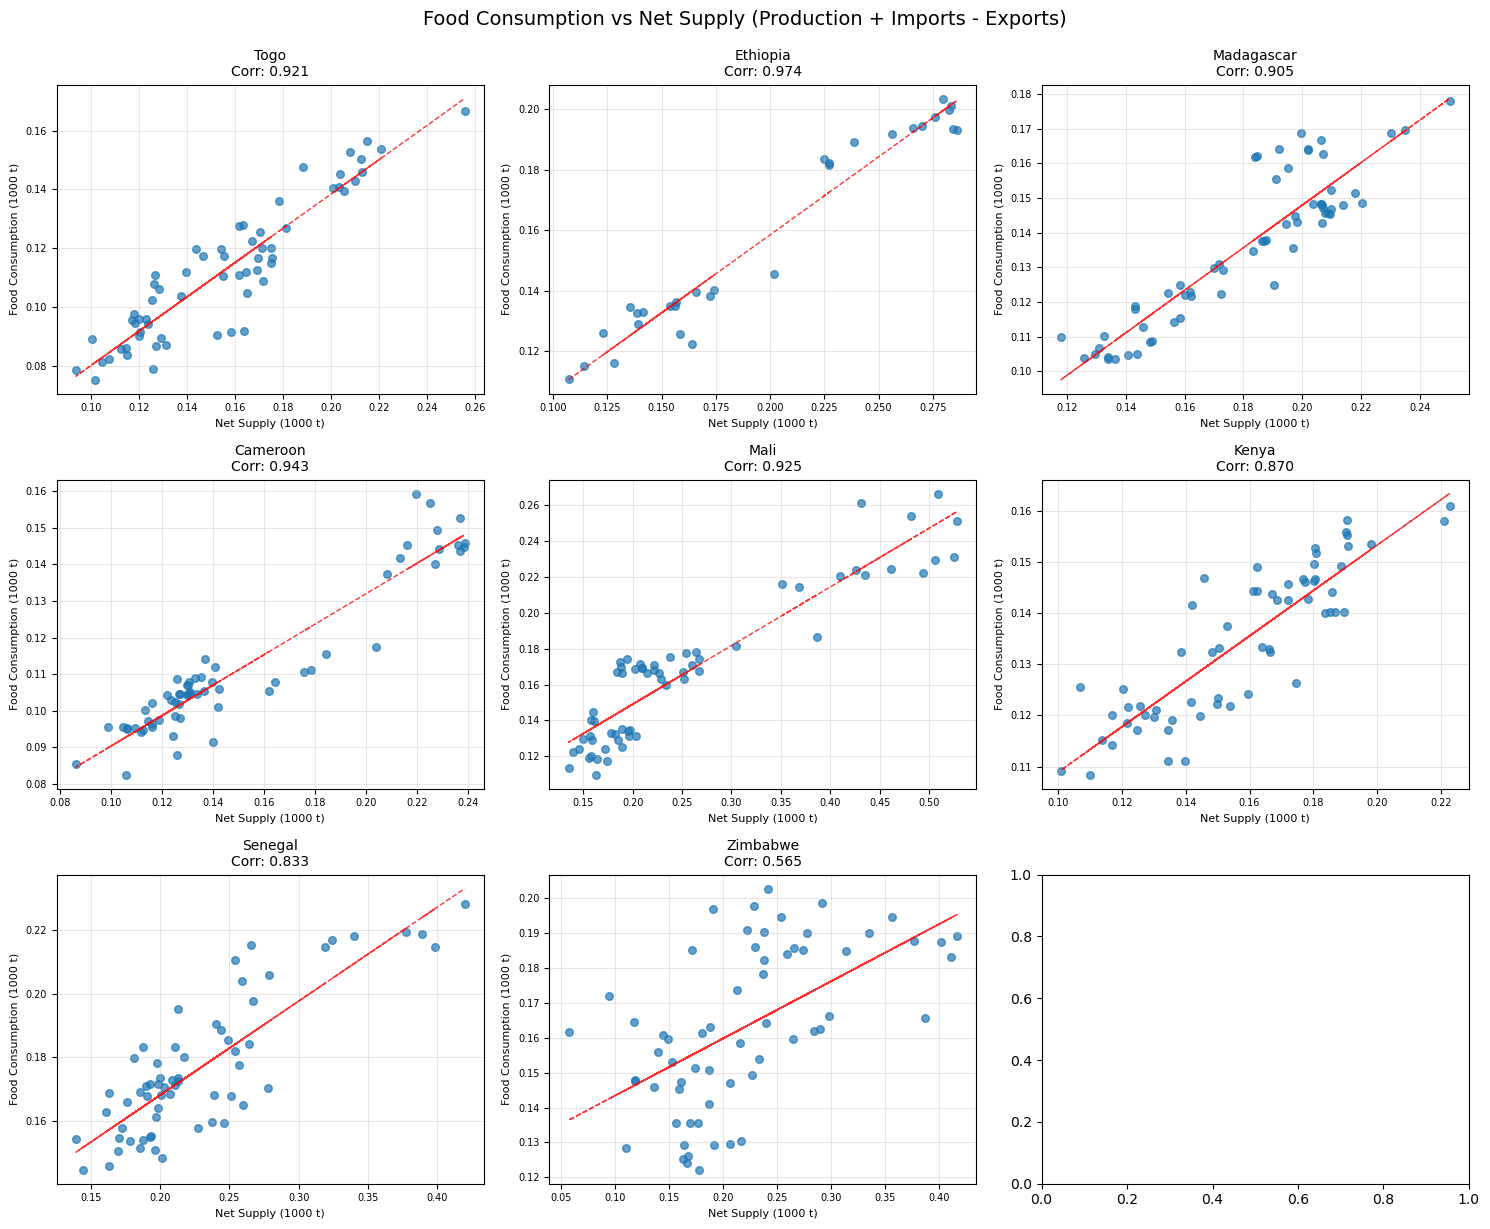


Selected Countries Correlation Summary:
Togo                 Correlation: 0.921    Years: 1961-2022
Ethiopia             Correlation: 0.974    Years: 1993-2022
Madagascar           Correlation: 0.905    Years: 1961-2022
Cameroon             Correlation: 0.943    Years: 1961-2022
Mali                 Correlation: 0.925    Years: 1961-2022
Kenya                Correlation: 0.870    Years: 1961-2022
Senegal              Correlation: 0.833    Years: 1961-2022
Zimbabwe             Correlation: 0.565    Years: 1961-2022


In [454]:
# Select countries for plotting: top correlations, middle, and Zimbabwe
selected_countries = ['Togo', 'Ethiopia', 'Madagascar', 'Cameroon', 'Mali', 'Kenya', 'Senegal', 'Zimbabwe']

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, country in enumerate(selected_countries):
    if country in FBS_Cereals_Complete_National['Area'].unique():
        # Filter data for this country
        country_data = FBS_Cereals_Complete_National[FBS_Cereals_Complete_National['Area'] == country]
        
        # Get unique years for this country
        years = sorted(country_data['Year'].unique())
        
        # Initialize lists to store values
        food_values = []
        net_supply_values = []
        year_list = []
        
        for year in years:
            year_data = country_data[country_data['Year'] == year]
            
            # Extract values for each component
            populations = National_Populations_Data[(National_Populations_Data['Area'] == country) &(National_Populations_Data['Year'] == year) & (National_Populations_Data.Element == "Total Population - Both sexes")]["Value"].iloc[0]
            food = year_data[year_data['Element'] == 'Food']['Value'].sum()/populations
            production = year_data[year_data['Element'] == 'Production']['Value'].sum()
            imports = year_data[year_data['Element'] == 'Import quantity']['Value'].sum()
            exports = year_data[year_data['Element'] == 'Export quantity']['Value'].sum()
            
            # Calculate net supply (Production + Imports - Exports)
            net_supply = (production + imports - exports)/populations
            
            # Only include years where we have both food and supply data
            if food > 0 and net_supply > 0:
                food_values.append(food)
                net_supply_values.append(net_supply)
                year_list.append(year)
        
        # Plot if we have data
        if len(food_values) >= 5:
            ax = axes[idx]
            
            # Scatter plot
            ax.scatter(net_supply_values, food_values, alpha=0.7, s=30)
            
            # Add trend line
            if len(food_values) > 1:
                z = np.polyfit(net_supply_values, food_values, 1)
                p = np.poly1d(z)
                ax.plot(net_supply_values, p(net_supply_values), "r--", alpha=0.8, linewidth=1)
            
            # Calculate and display correlation
            if country in correlations_food_supply:
                corr = correlations_food_supply[country]['correlation']
                ax.set_title(f'{country}\nCorr: {corr:.3f}', fontsize=10)
            else:
                ax.set_title(f'{country}', fontsize=10)
            
            ax.set_xlabel('Net Supply (1000 t)', fontsize=8)
            ax.set_ylabel('Food Consumption (1000 t)', fontsize=8)
            ax.grid(True, alpha=0.3)
            ax.tick_params(axis='both', which='major', labelsize=7)
        else:
            axes[idx].text(0.5, 0.5, f'{country}\nInsufficient data', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].set_xticks([])
            axes[idx].set_yticks([])

plt.tight_layout()
plt.suptitle('Food Consumption vs Net Supply (Production + Imports - Exports)', 
             fontsize=14, y=1.02)
plt.show()

# Print correlation summary for selected countries
print("\nSelected Countries Correlation Summary:")
print("=" * 60)
for country in selected_countries:
    if country in correlations_food_supply:
        data = correlations_food_supply[country]
        print(f"{country:<20} Correlation: {data['correlation']:<8.3f} Years: {data['years_range']}")
    else:
        print(f"{country:<20} No data available")